In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
plt.style.use('dark_background') 

def highlight_odd_rows(s):
    '''
    Changes style of a dataframe visualization
    Args:
       s : The row of the dataframe
    Returns:
    '''
    styles = []
    for i in range(len(s)):
        if i % 2 == 1:
            styles.append('background-color: indigo; border: 1px solid white;')
        else:
            styles.append('border: 1px solid white;')
    return styles

In [3]:
class DataFrame_analysis:
    '''
    This class contains every method for regularization microservice function analysis
    '''
    #Class variables

    #The init method 
    def __init__(self):
        pass

    #Public
    def getDfSize(self, df):
        '''
        Returns the rows and columns of a dataframe
        Args:
           df (Dataframe) : Dataframe to analyze
        Returns:
          ... (dictionary): A dictionary with rows and columns as keys
        '''
        rows = len(df.axes[0])
        columns = len(df.axes[1])
        return {'rows': rows, 'columns': columns}

    #Public
    def determineDistinctValues(self, df, col):
        '''
        Determines the unrepeated values in a columns
        Args:
           df (DataFrame) : Dataframe which contains the column to search
           col (string) : Column's name to search
        Returns:
           df[col].unique() (array): An array (iterable object) with the unrepeated values of the column
        '''
        return df[col].unique()

    #Public
    def determineDistinctKeys(self, columnToList):
        '''
        Extracts the keys of a dictionary list and saves it in a dictionary with its count of appearences in the list
        Args:
           columnList (list) : List of dictionary to extract the keys
        Returns:
           distinctKeys (dictionary): A dictionary with the keys as a string and its appearences count in the list
        '''
        distinctKeysDict = {}
        distinctKeysList = []
        for dictionary in columnToList:
            dictionary = json.loads(dictionary)
            orderedKeys = sorted(list(dictionary.keys()))
            if orderedKeys in distinctKeysList:
                distinctKeysDict['/'.join(orderedKeys)] += 1
            else:
                distinctKeysList.append(orderedKeys)
                distinctKeysDict['/'.join(orderedKeys)] = 0
        return distinctKeysDict

    #Public
    def countAlertCodes(self, df, alertsColumn: str):
        '''
        Counts the alert codes in a column of a dataframe
        Args:
           df (DataFrame) : Dataframe which contains the column to search
           alertsColumn (string) : Column's name to search
        Returns:
           codeCount (dictionary): A dictionary with the distinct alert codes as keys and the appearence count in the column
        '''
        alertsWithCode = filter(lambda x: x != [],df['alertas'].values.tolist())
        codeCount = {'Code 1': 0 , 'Code 2': 0, 'Code 3': 0, 'Code 4': 0, 'Code 5': 0, 'Code 6': 0, 'Code 7': 0}

        for alert in alertsWithCode:
            alertList = json.loads(alert)
            if alertList != []:
                for subalert in alertList:
                    n = subalert['codigo']
                    codeCount[''.join(['Code ', str(n)])] += 1
    
        return codeCount

    #Public
    def calculateDeltaTime(self, df, columnA, columnB):
        '''
        Converts columnA and columnB in datetime type and makes the difference between both columns
        Args:
           df (DataFrame) : Dataframe which contains the columns to substraction
           columnA (string) : Minuend column
           columnB (string): Substrahend column
        Returns:
           responsePeriod (DataFrame): Returns a column of the seconds difference as a dataframe
        '''
        responseTimeType = pd.to_datetime(df[columnA], format='%d/%m/%Y %H:%M:%S')
        requestTimeType = pd.to_datetime(df[columnB], format='%d/%m/%Y %H:%M:%S')
        responsePeriod = (responseTimeType - requestTimeType).to_frame()
        responsePeriod['secondsDifference'] = pd.to_timedelta(responsePeriod[0]).dt.total_seconds()
        responsePeriod.drop([0], axis='columns', inplace=True)

        return responsePeriod

    #Public
    def proveErrorAlert(self, df):
        '''
        Assures every error in CarfaxUsaData is associated with an alert
        Args:
           df (DataFrame) : Dataframe which contains the columns to substraction
        Returns:
           ... (string): Returns a status message
        '''
        carfaxUsaData = df['carfaxUsaData'].values.tolist()
        conError = 0
        for index1 in range(len(carfaxUsaData)):
            carfaxDict = json.loads(carfaxUsaData[index1])
            if 'error' in list(carfaxDict.keys()):
                conError += 1
                if df.iloc[index1]['alertas'] == []:
                    return True
        return False

    #Private
    def getRepeatedValuesInAColumn(self, df, columnName):
        '''
        Identifies the repeated values of a column in a dataframe
        Args:
           df (DataFrame) : Dataframe which contains the columns to search
           columnName (string) : Column's name to search
        Returns:
           duplicates['VIN'] (pandas Series): Returns a column as a pandas series of the duplicated values of the columnName
        '''
        duplicates = df[df.duplicated(subset=[columnName], keep=False)]
        return duplicates['VIN']

    #Private
    def searchValuesInADataframe(self, df, values:list, columnA: str, columnB: str)-> dict:
        '''
        Searches the values of a list in a dataframe columnA and retrieves the information of columnB
        Args:
           values (list): The list of values to be searched
           columnA (string): The name's column to search
           columnB (string): The name's column to retrieve values
           df (DataFrame): The dataframe where where will be searched
        Returns:
          valuesBDict (dict): A dictionary of values as key and the retrieved values of columnB as values
        '''
        valuesBDict ={}
        for value in values:
            valuesB = df.loc[df[columnA]== value, columnB].tolist()
            valuesBDict[value] = valuesB
        return valuesBDict

    #Public
    def getIncorrectRepeatedVinInformation(self, df)->dict:
        '''
        Searches the values of a list in a dataframe columnA and retrieves the information of columnB
        Args:
           df (DataFrame): The dataframe where where will be searched
        Returns:
          ... (dict): A dictionary which contains a status message, a list of good and bad VINs withits appeareance count, and the total count of good and bad VINS
        '''
        repeatedRows = len(self.getRepeatedValuesInAColumn(df, 'VIN').values.tolist())
        vinValues = self.getRepeatedValuesInAColumn(df, 'VIN').unique().tolist()
        repeatedVins = len(vinValues)
        repeatedValues = self.searchValuesInADataframe(df, vinValues, 'VIN', 'alertas')
        goodVins = 0
        badVins = 0
        goodVinsList = []
        badVinsList = []
        for repeatedVin in list(repeatedValues.keys()):
            differentValuesByVin = list(set(repeatedValues[repeatedVin]))
            for differentValue in differentValuesByVin:
                if differentValue == '[]':
                    goodVins += 1
                    if len(differentValuesByVin)>1:
                        return {'message': ''.join(['Alerta con vin: ',repeatedVin, ' , tiene y no tiene alertas.']),
                               'goodVinsList': [],
                               'badVinsList': [],
                              'goodVins':0,
                               'badVins': 0}
                    else:
                        goodVinsList.append([repeatedVin, len(repeatedValues[repeatedVin])])
                else:
                    badVins += 1
                    badVinsList.append([repeatedVin, len(repeatedValues[repeatedVin])])
            

        return {'message': '',
               'goodVinsList': goodVinsList,
               'badVinsList': badVinsList,
               'goodVins':goodVins,
               'badVins': badVins}

    #Public
    def diagnoseVins(self, df):
        '''
        Converts the lists of  getIncorrectRepeatedVinInformation() function in dataframes
        Args:
           df (DataFrame): The dataframe where where will be searched
        Returns:
          ... (dict): A dictionary which contains the good and bad VINs dataframes and the good and bad repeated Records of the VINs
        '''
        goodVinsFrame = pd.DataFrame(self.getIncorrectRepeatedVinInformation(df)['goodVinsList'], columns = ['VIN', 'repeatedTimes'])
        goodRepeatedRecords = goodVinsFrame.sum()['repeatedTimes']
        badVinsFrame = pd.DataFrame(self.getIncorrectRepeatedVinInformation(df)['badVinsList'], columns = ['VIN', 'repeatedTimes'])
        badRepeatedRecords = badVinsFrame.sum()['repeatedTimes']

        return {'goodVinsFrame': goodVinsFrame, 'badVinsFrame': badVinsFrame, 'goodRepeatedRecords': goodRepeatedRecords, 'badRepeatedRecords': badRepeatedRecords}

    def verifyInfoRepeatedVins(self, df):
        '''
        Verifies every repeated VIN has the same information in every record (due to the short period time reviewed)
        Args:
           df (DataFrame): The dataframe where where will be searched
        Returns:
          ... (dict): A dictionary which contains the different responses as a dict for every repeated VIN in uniqueResponses and VINs with more than one response in differentResponse key
        '''
        uniqueResponses = {}
        differentResponses = {}
        vinValues = self.getRepeatedValuesInAColumn(df, 'VIN').unique().tolist()
        repeatedValues = self.searchValuesInADataframe(df, vinValues, 'VIN', 'responseBody')
        repeatedVins = repeatedValues.keys()
        for vin in repeatedVins:
            uniqueResponses[vin] = []
            listJson = []
            for responseString in repeatedValues[vin]:
                responseJson = json.loads(responseString)
                listJson.append(responseJson)
            repeatedValues[vin] = listJson
        for vin in repeatedVins:
            for responseJson in repeatedValues[vin]:
                info = {'anioModelo': responseJson['anioModelo'], 'fabricante': responseJson['fabricante'], 'marca': responseJson['marca'], 'modelo': responseJson['modelo'], 'paisOrigen': responseJson['paisOrigen'], 'robo': responseJson['robo'], 'roboFecha': responseJson['roboFecha'], 'codes': []}
                if  responseJson['mensajes'] != []:
                    for message in responseJson['mensajes']:
                        info['codes'].append(message['codigo'])
                        info['codes'] = list(set(info['codes']))
                    if len(info['codes'])>1:
                        info['codes'] = info['codes'].sort()
                if uniqueResponses[vin] == []:
                     uniqueResponses[vin].append(info)
                else:
                    if info not in uniqueResponses[vin]:
                        uniqueResponses[vin].append(info)
                        info['tiempoRespuesta'] = responseJson['tiempoRespuesta']
                        differentResponses[vin] = info
        return {'uniqueResponses': uniqueResponses, 'differentResponses': differentResponses}

In [4]:
regularizationFrame = pd.read_csv("consultassec.csv", encoding = 'utf-8').sort_values(by = 'responseTime', ascending = False)

first 2024-11-05 10:14:00
first ['2024-11-05T10:14:00.000000000'] ['672a4448124bd56498eadd98']
last ['2024-11-05T10:09:11.000000000'] ['672a432769994fdacd6fe521']


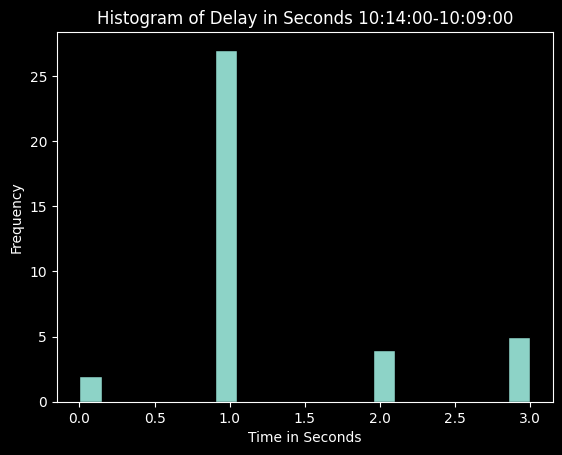

39
first 2024-11-05 10:08:47
first ['2024-11-05T10:08:47.000000000'] ['672a430f7384826621095db6']
last ['2024-11-05T10:03:57.000000000'] ['672a41ed7384826621095d9a']


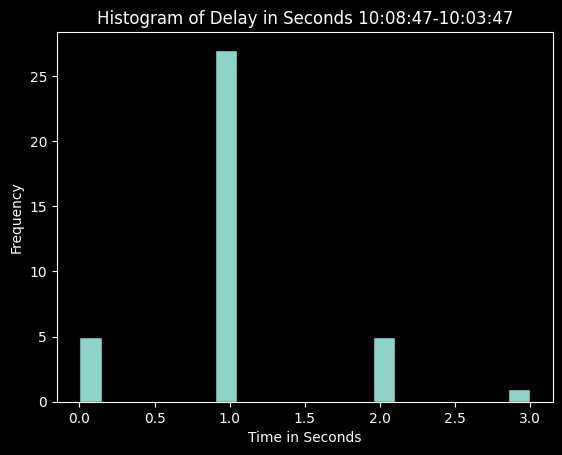

77
first 2024-11-05 10:03:08
first ['2024-11-05T10:03:08.000000000'] ['672a41bc7384826621095d98']
last ['2024-11-05T09:58:12.000000000'] ['672a409469994fdacd6fe4f3']


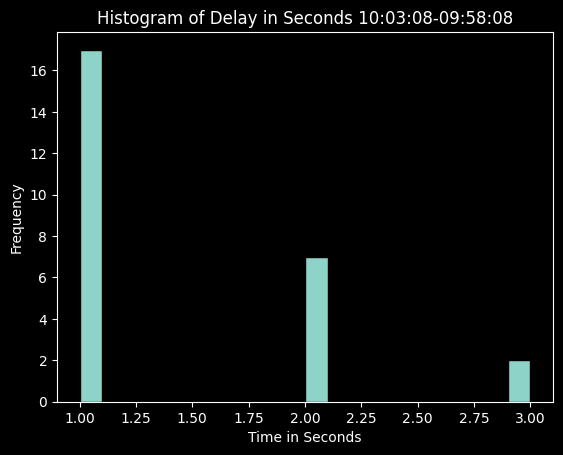

103
first 2024-11-05 09:57:14
first ['2024-11-05T09:57:14.000000000'] ['672a405a7384826621095d84']
last ['2024-11-05T09:52:16.000000000'] ['672a3f307384826621095d76']


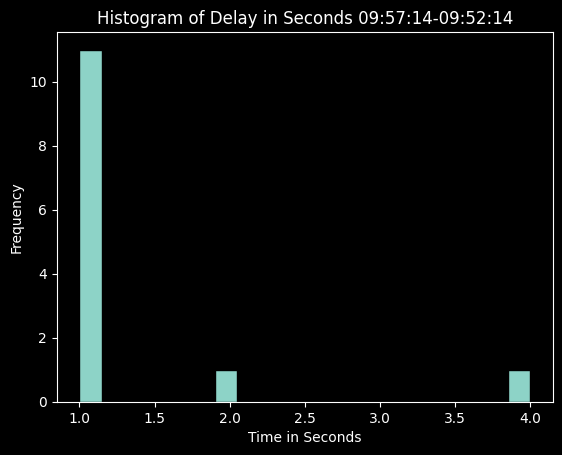

116
first 2024-11-05 09:52:03
first ['2024-11-05T09:52:03.000000000'] ['672a3f2369994fdacd6fe4eb']
last ['2024-11-05T09:47:25.000000000'] ['672a3e0d69994fdacd6fe4d9']


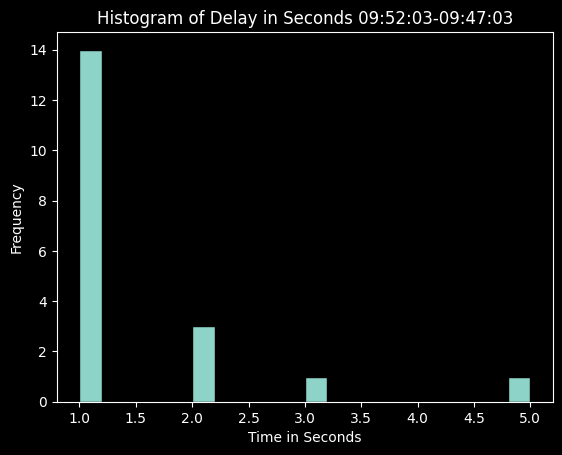

135
first 2024-11-05 09:46:56
first ['2024-11-05T09:46:56.000000000'] ['672a3df0124bd56498eadd52']
last ['2024-11-05T09:42:03.000000000'] ['672a3ccb124bd56498eadd40']


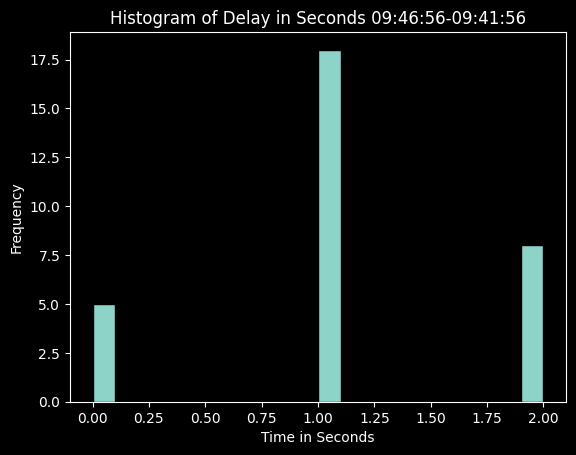

166
first 2024-11-05 09:41:39
first ['2024-11-05T09:41:39.000000000'] ['672a3cb3124bd56498eadd3e']
last ['2024-11-05T09:36:54.000000000'] ['672a3b967384826621095d4e']


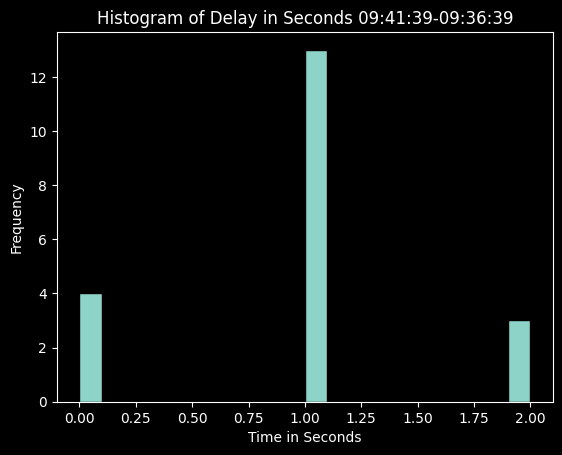

186
first 2024-11-05 09:36:30
first ['2024-11-05T09:36:30.000000000'] ['672a3b7e7384826621095d4c']
last ['2024-11-05T09:31:59.000000000'] ['672a3a6f124bd56498eadd22']


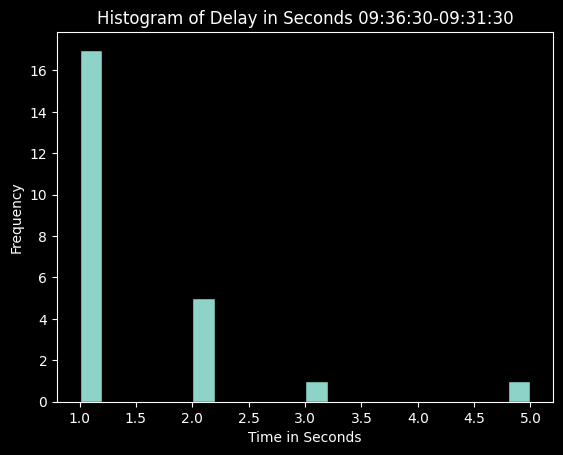

210
first 2024-11-05 09:31:11
first ['2024-11-05T09:31:11.000000000'] ['672a3a3f124bd56498eadd20']
last ['2024-11-05T09:26:46.000000000'] ['672a393669994fdacd6fe4a7']


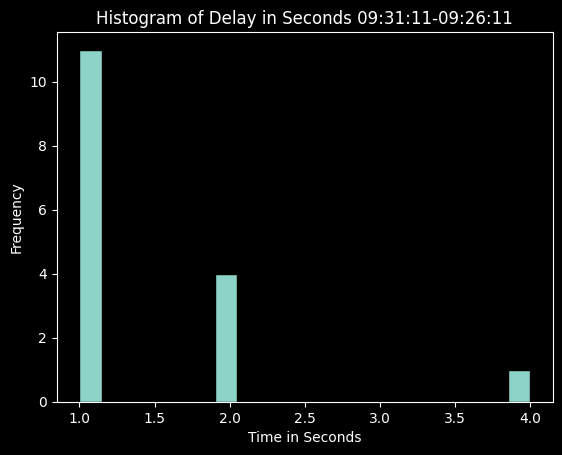

226
first 2024-11-05 09:25:28
first ['2024-11-05T09:25:28.000000000'] ['672a38e87384826621095d2a']
last ['2024-11-05T09:20:43.000000000'] ['672a37cb124bd56498eadd0c']


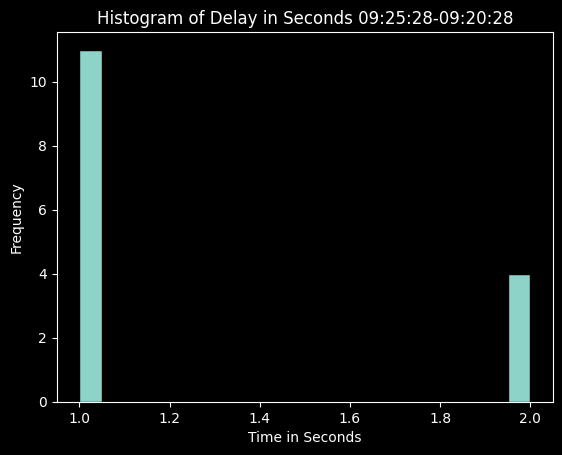

241
first 2024-11-05 09:20:26
first ['2024-11-05T09:20:26.000000000'] ['672a37ba124bd56498eadd0a']
last ['2024-11-05T09:15:46.000000000'] ['672a36a27384826621095d0a']


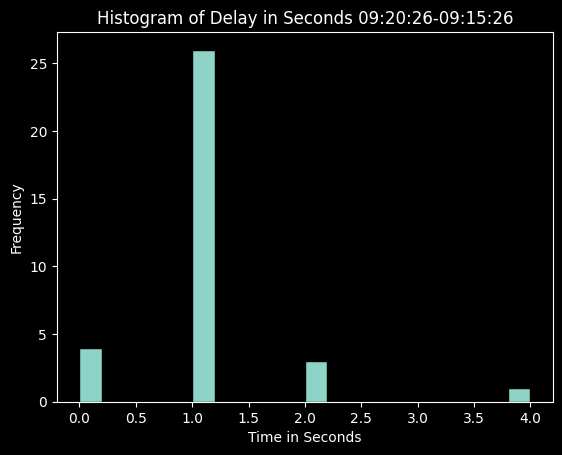

275
first 2024-11-05 09:15:08
first ['2024-11-05T09:15:08.000000000'] ['672a367c124bd56498eadcee']
last ['2024-11-05T09:10:12.000000000'] ['672a355469994fdacd6fe47b']


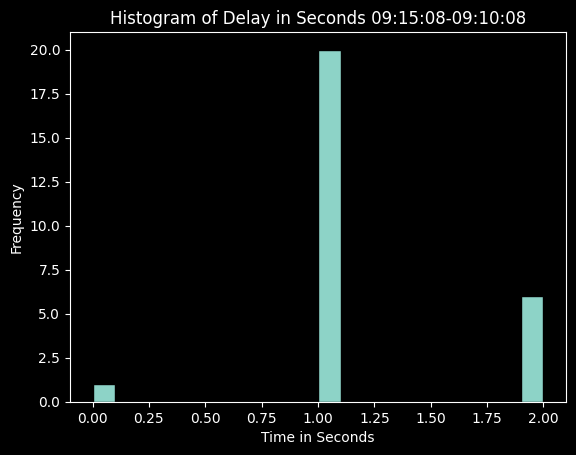

302
first 2024-11-05 09:09:53
first ['2024-11-05T09:09:53.000000000'] ['672a3541124bd56498eadcd8']
last ['2024-11-05T09:05:03.000000000'] ['672a341f69994fdacd6fe471']


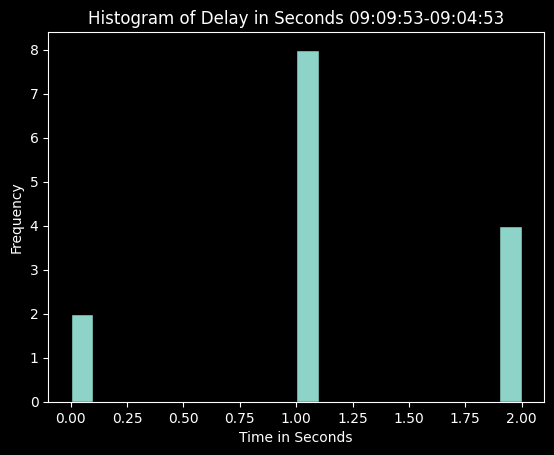

316
first 2024-11-05 09:04:50
first ['2024-11-05T09:04:50.000000000'] ['672a34127384826621095cf0']
last ['2024-11-05T08:59:57.000000000'] ['672a32ed7384826621095cee']


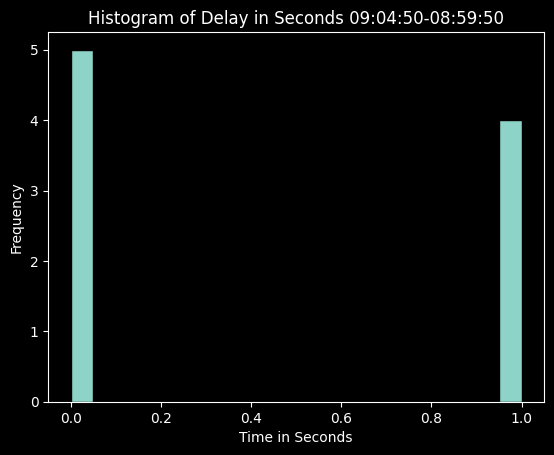

325
first 2024-11-05 08:59:48
first ['2024-11-05T08:59:48.000000000'] ['672a32e47384826621095cec']
last ['2024-11-05T08:55:07.000000000'] ['672a31cb7384826621095cd4']


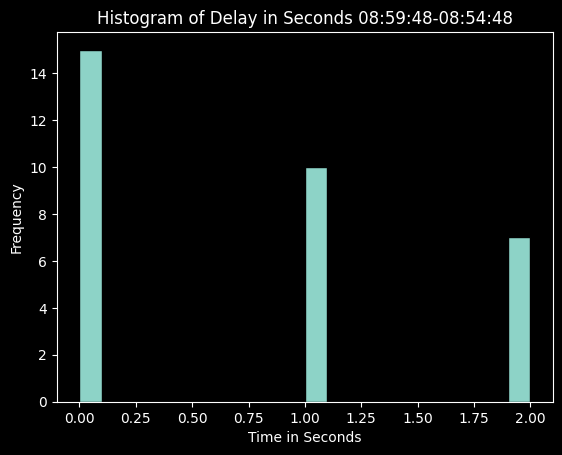

357
first 2024-11-05 08:54:14
first ['2024-11-05T08:54:14.000000000'] ['672a31967384826621095cd2']
last ['2024-11-05T08:50:03.000000000'] ['672a309b124bd56498eadcae']


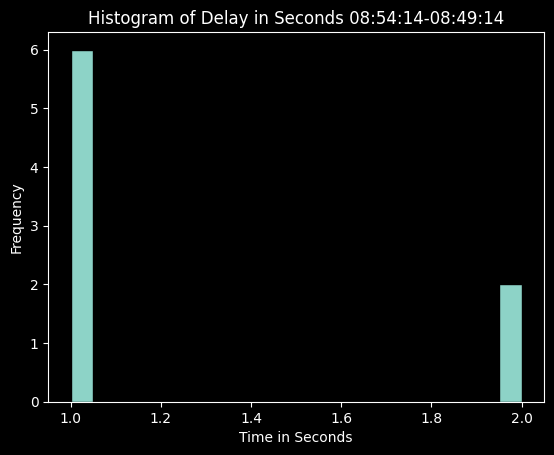

365
first 2024-11-05 08:49:13
first ['2024-11-05T08:49:13.000000000'] ['672a306969994fdacd6fe453']
last ['2024-11-05T08:44:29.000000000'] ['672a2f4d69994fdacd6fe43d']


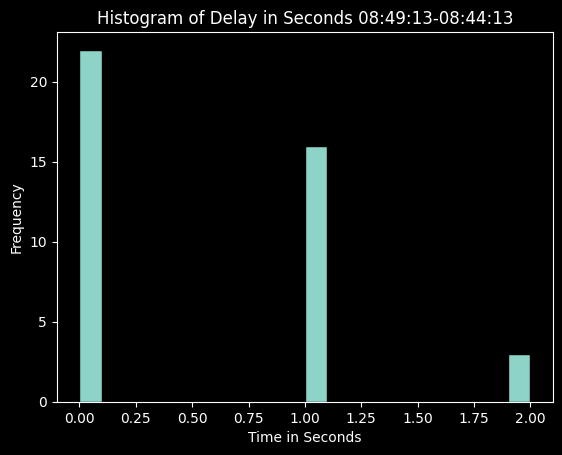

406
first 2024-11-05 08:44:12
first ['2024-11-05T08:44:12.000000000'] ['672a2f3c7384826621095cb0']
last ['2024-11-05T08:39:24.000000000'] ['672a2e1c7384826621095c96']


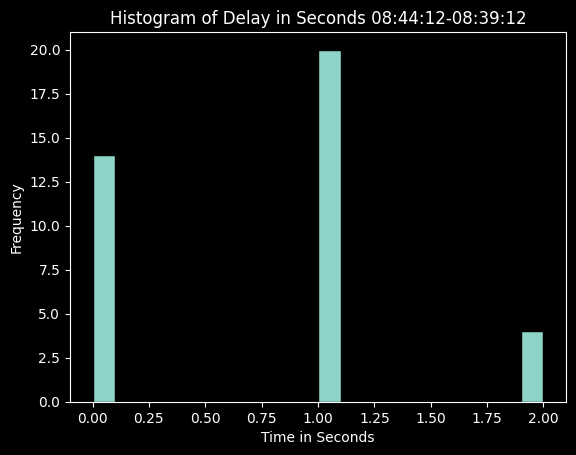

444
first 2024-11-05 08:39:10
first ['2024-11-05T08:39:10.000000000'] ['672a2e0e69994fdacd6fe421']
last ['2024-11-05T08:34:28.000000000'] ['672a2cf469994fdacd6fe417']


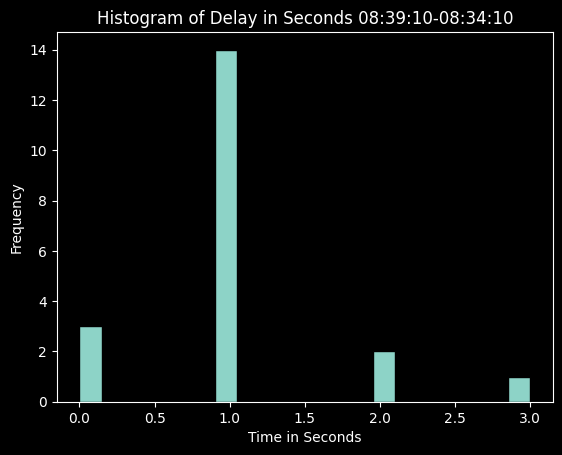

464
first 2024-11-05 08:33:06
first ['2024-11-05T08:33:06.000000000'] ['672a2ca269994fdacd6fe415']
last ['2024-11-05T08:28:12.000000000'] ['672a2b7c124bd56498eadc62']


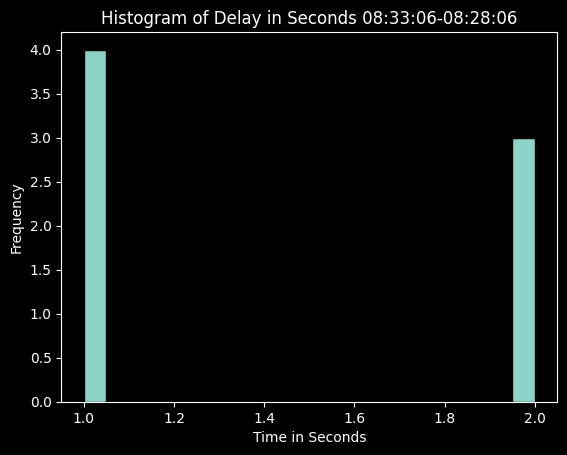

471
first 2024-11-05 08:27:57
first ['2024-11-05T08:27:57.000000000'] ['672a2b6d7384826621095c86']
last ['2024-11-05T08:25:04.000000000'] ['672a2ac069994fdacd6fe40b']


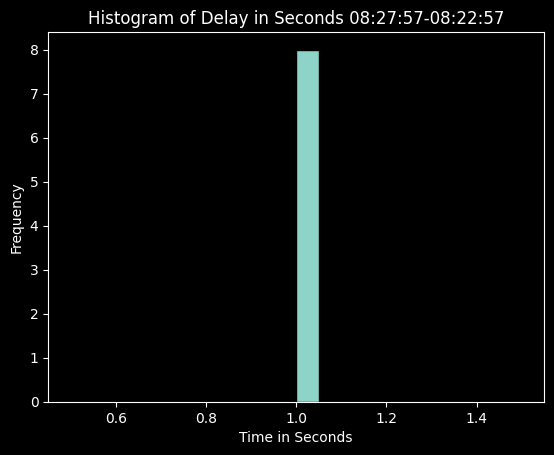

479
first 2024-11-05 08:21:27
first ['2024-11-05T08:21:27.000000000'] ['672a29e7124bd56498eadc5c']
last ['2024-11-05T08:16:29.000000000'] ['672a28bd124bd56498eadc3a']


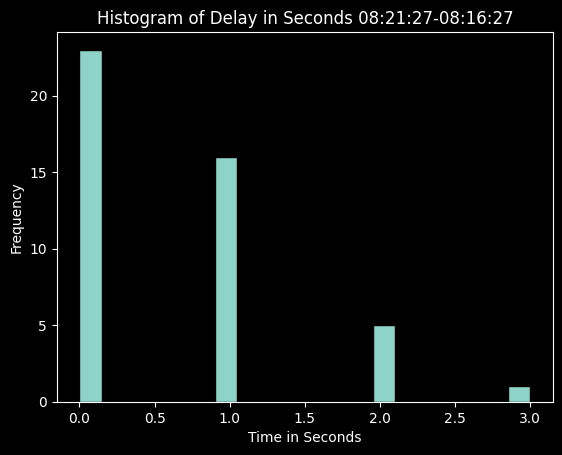

524
first 2024-11-05 08:16:11
first ['2024-11-05T08:16:11.000000000'] ['672a28ab124bd56498eadc38']
last ['2024-11-05T08:11:22.000000000'] ['672a278a69994fdacd6fe3e5']


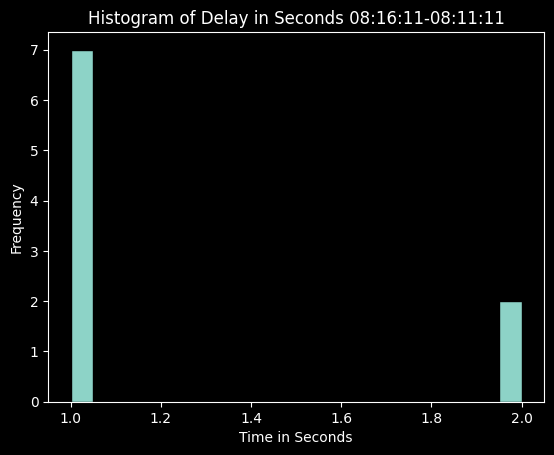

533
first 2024-11-05 08:11:04
first ['2024-11-05T08:11:04.000000000'] ['672a2778124bd56498eadc30']
last ['2024-11-05T08:07:00.000000000'] ['672a2684124bd56498eadc2e']


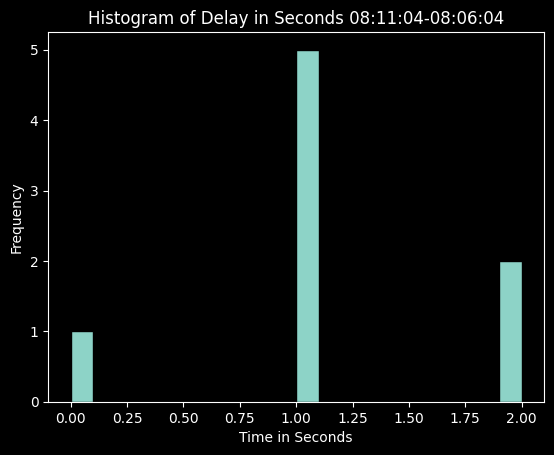

541
first 2024-11-05 08:05:49
first ['2024-11-05T08:05:49.000000000'] ['672a263d124bd56498eadc2c']
last ['2024-11-05T08:00:54.000000000'] ['672a2516124bd56498eadc28']


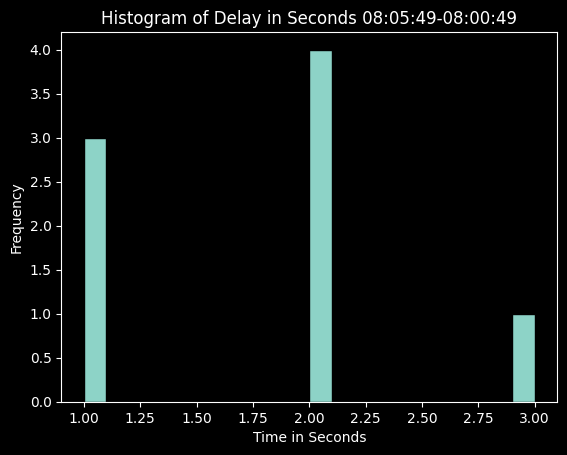

549
first 2024-11-05 08:00:25
first ['2024-11-05T08:00:25.000000000'] ['672a24f9124bd56498eadc26']
last ['2024-11-05T07:56:42.000000000'] ['672a241a7384826621095c5e']


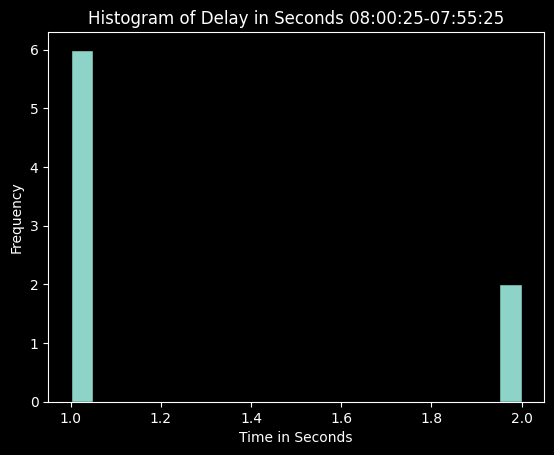

557
first 2024-11-05 07:54:41
first ['2024-11-05T07:54:41.000000000'] ['672a23a169994fdacd6fe3cf']
last ['2024-11-05T07:50:41.000000000'] ['672a22b1124bd56498eadc1e']


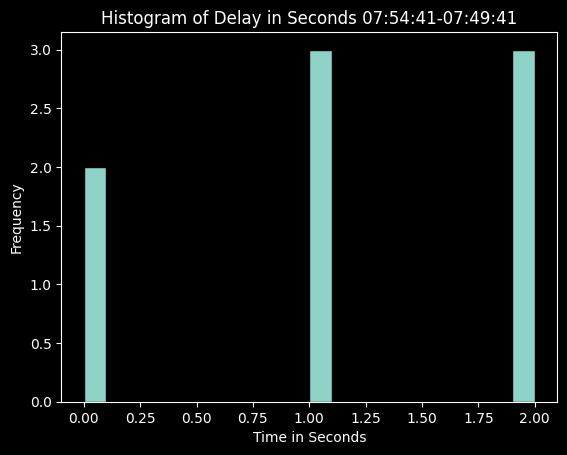

565
first 2024-11-05 07:49:24
first ['2024-11-05T07:49:24.000000000'] ['672a22647384826621095c58']
last ['2024-11-05T07:49:24.000000000'] ['672a22647384826621095c58']


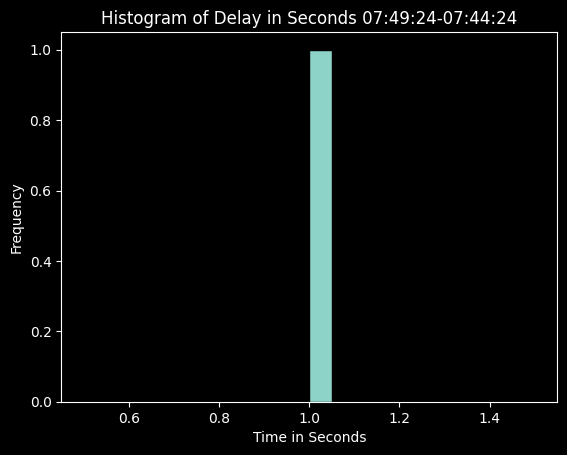

566
first 2024-11-05 07:38:49
first ['2024-11-05T07:38:49.000000000'] ['672a1fe97384826621095c56']
last ['2024-11-05T07:34:07.000000000'] ['672a1ecf7384826621095c54']


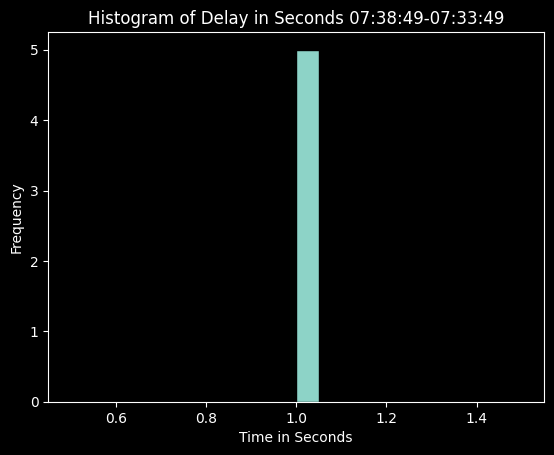

571
first 2024-11-05 07:33:38
first ['2024-11-05T07:33:38.000000000'] ['672a1eb269994fdacd6fe3c1']
last ['2024-11-05T07:30:22.000000000'] ['672a1dee7384826621095c4e']


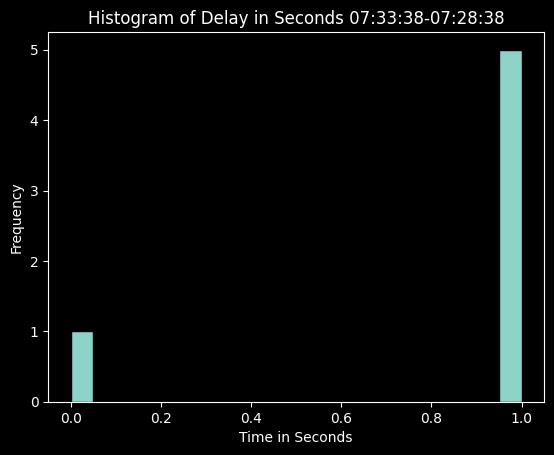

577
first 2024-11-05 07:28:33
first ['2024-11-05T07:28:33.000000000'] ['672a1d817384826621095c4c']
last ['2024-11-05T07:24:11.000000000'] ['672a1c7b69994fdacd6fe3b5']


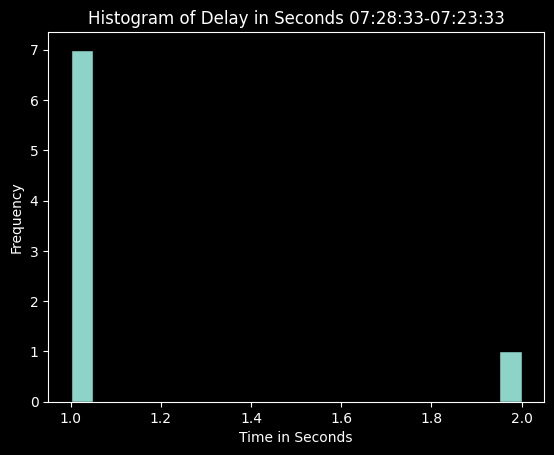

585
first 2024-11-05 07:20:23
first ['2024-11-05T07:20:23.000000000'] ['672a1b977384826621095c48']
last ['2024-11-05T07:16:47.000000000'] ['672a1abf69994fdacd6fe3b1']


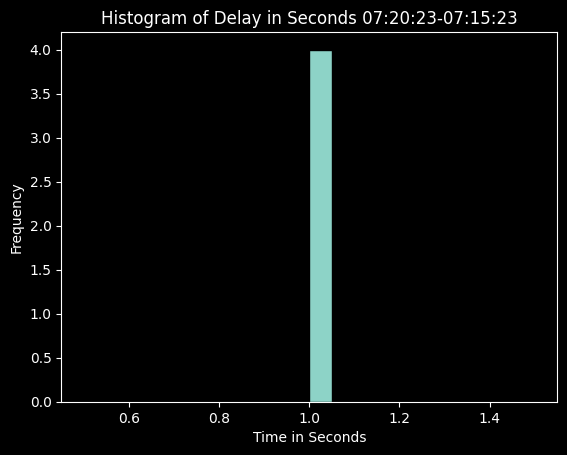

589
first 2024-11-05 07:11:55
first ['2024-11-05T07:11:55.000000000'] ['672a199b7384826621095c46']
last ['2024-11-05T07:09:13.000000000'] ['672a18f97384826621095c44']


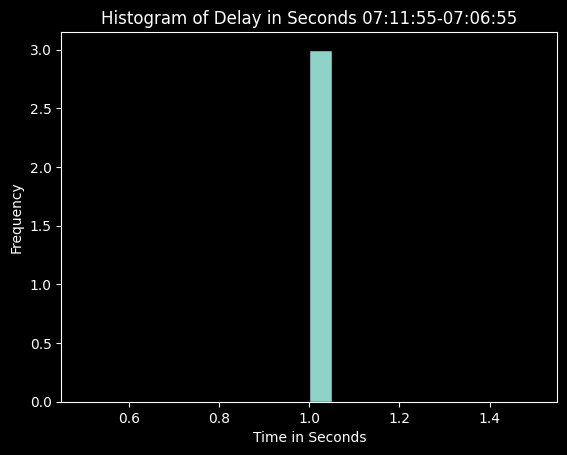

592
first 2024-11-05 07:06:44
first ['2024-11-05T07:06:44.000000000'] ['672a186469994fdacd6fe3af']
last ['2024-11-05T07:03:50.000000000'] ['672a17b669994fdacd6fe3ab']


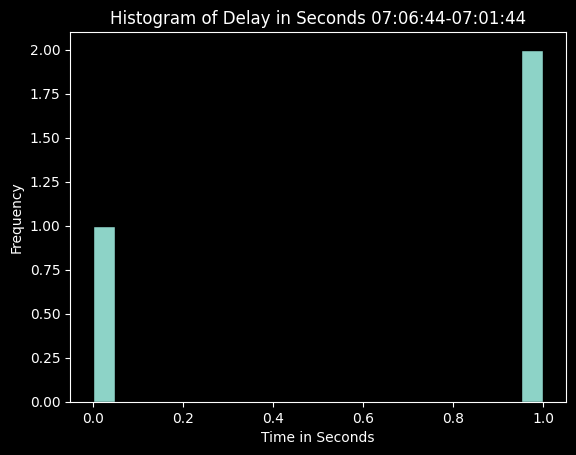

595
first 2024-11-05 06:56:07
first ['2024-11-05T06:56:07.000000000'] ['672a15e77384826621095c42']
last ['2024-11-05T06:56:07.000000000'] ['672a15e77384826621095c42']


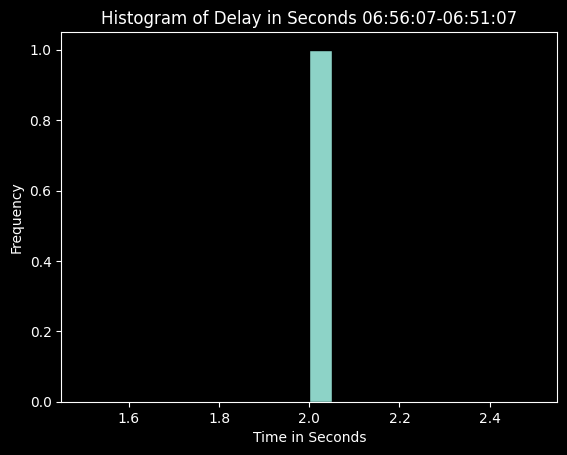

596
first 2024-11-05 06:46:27
first ['2024-11-05T06:46:27.000000000'] ['672a13a3124bd56498eadc14']
last ['2024-11-05T06:46:27.000000000'] ['672a13a3124bd56498eadc14']


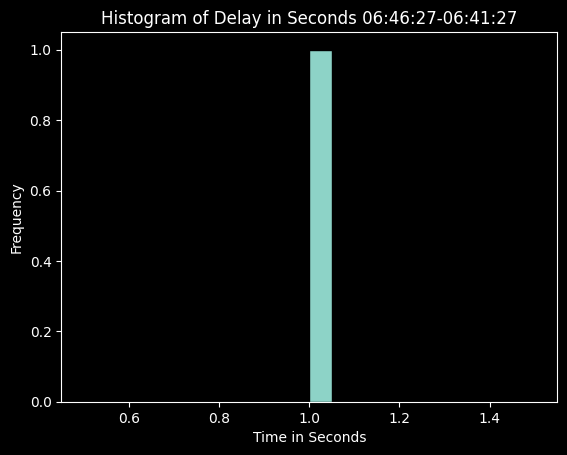

597
first 2024-11-05 06:28:45
first ['2024-11-05T06:28:45.000000000'] ['672a0f7d69994fdacd6fe3a9']
last ['2024-11-05T06:23:59.000000000'] ['672a0e5f124bd56498eadc12']


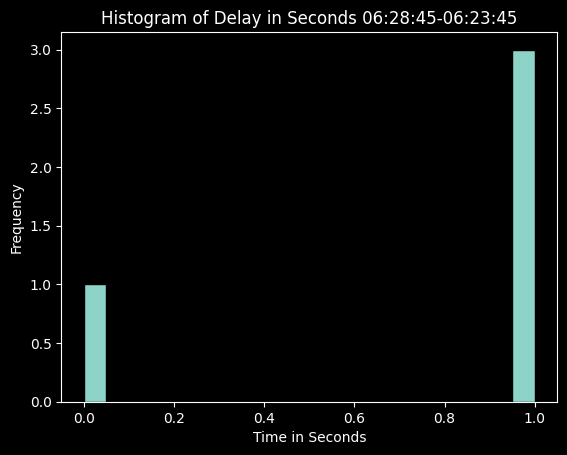

601
first 2024-11-05 06:23:43
first ['2024-11-05T06:23:43.000000000'] ['672a0e4f7384826621095c3e']
last ['2024-11-05T06:23:43.000000000'] ['672a0e4f7384826621095c3e']


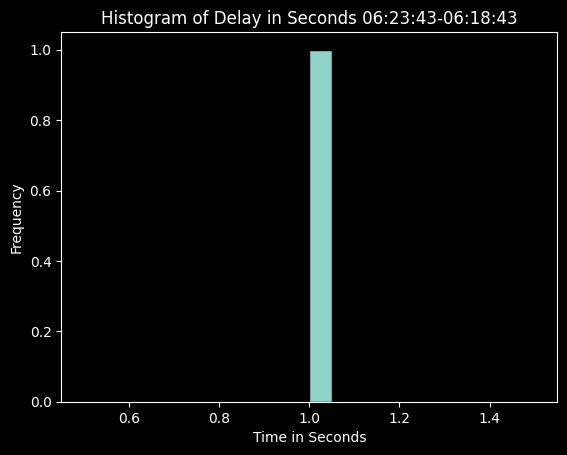

602
first 2024-11-05 06:13:45
first ['2024-11-05T06:13:45.000000000'] ['672a0bf969994fdacd6fe3a5']
last ['2024-11-05T06:09:47.000000000'] ['672a0b0b124bd56498eadc10']


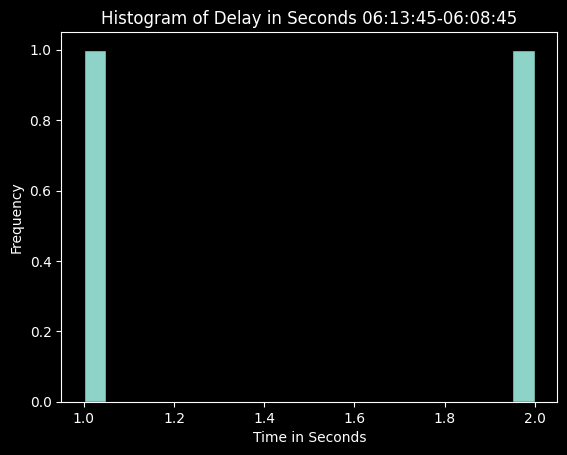

604
first 2024-11-05 05:52:51
first ['2024-11-05T05:52:51.000000000'] ['672a07137384826621095c3c']
last ['2024-11-05T05:52:51.000000000'] ['672a07137384826621095c3c']


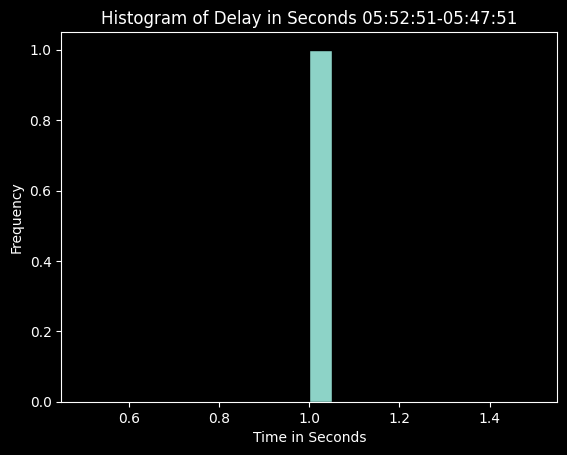

605
first 2024-11-05 05:26:17
first ['2024-11-05T05:26:17.000000000'] ['672a00d97384826621095c3a']
last ['2024-11-05T05:21:53.000000000'] ['6729ffd1124bd56498eadc0e']


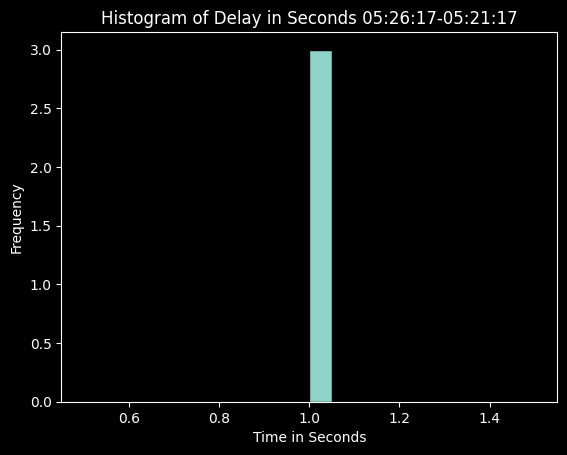

608
first 2024-11-05 04:25:54
first ['2024-11-05T04:25:54.000000000'] ['6729f2b27384826621095c36']
last ['2024-11-05T04:25:54.000000000'] ['6729f2b27384826621095c36']


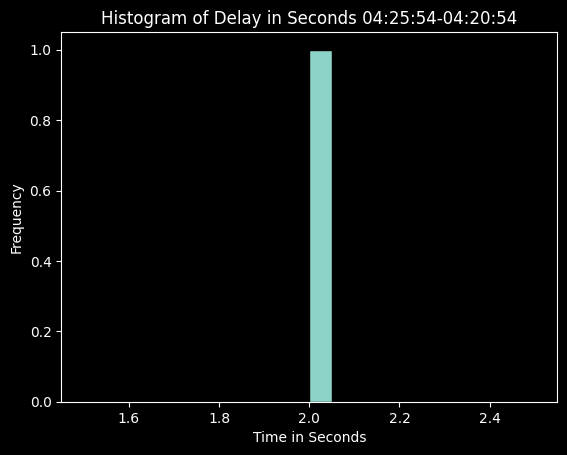

609
first 2024-11-05 03:48:16
first ['2024-11-05T03:48:16.000000000'] ['6729e9e0124bd56498eadc0c']
last ['2024-11-05T03:46:24.000000000'] ['6729e97069994fdacd6fe3a0']


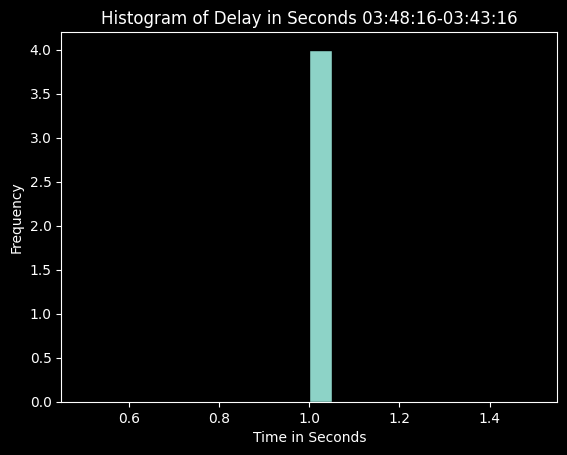

613
first 2024-11-05 03:41:18
first ['2024-11-05T03:41:18.000000000'] ['6729e83e69994fdacd6fe39c']
last ['2024-11-05T03:36:30.000000000'] ['6729e71e69994fdacd6fe397']


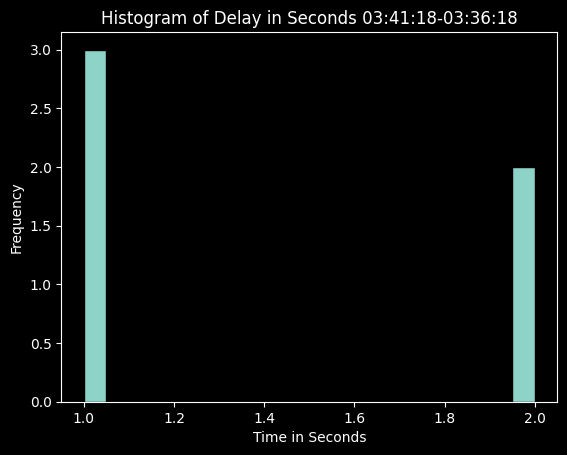

618
first 2024-11-05 03:35:36
first ['2024-11-05T03:35:36.000000000'] ['6729e6e869994fdacd6fe395']
last ['2024-11-05T03:30:38.000000000'] ['6729e5be124bd56498eadc06']


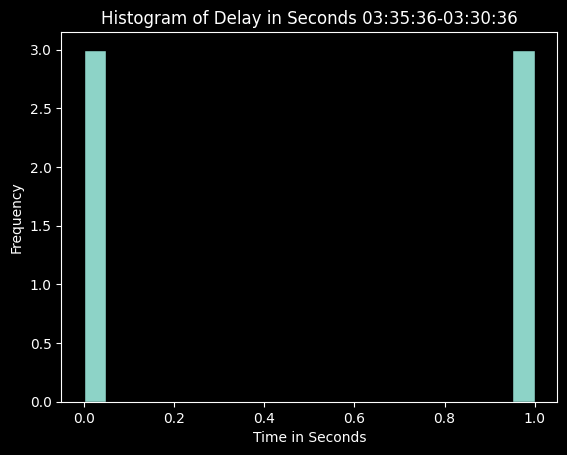

624
first 2024-11-05 03:18:53
first ['2024-11-05T03:18:53.000000000'] ['6729e2fd7384826621095c30']
last ['2024-11-05T03:16:33.000000000'] ['6729e271124bd56498eadc04']


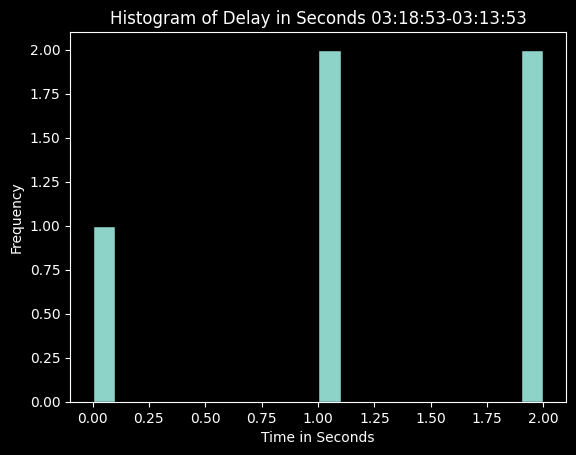

629
first 2024-11-05 03:12:32
first ['2024-11-05T03:12:32.000000000'] ['6729e18069994fdacd6fe38d']
last ['2024-11-05T03:08:58.000000000'] ['6729e0aa69994fdacd6fe389']


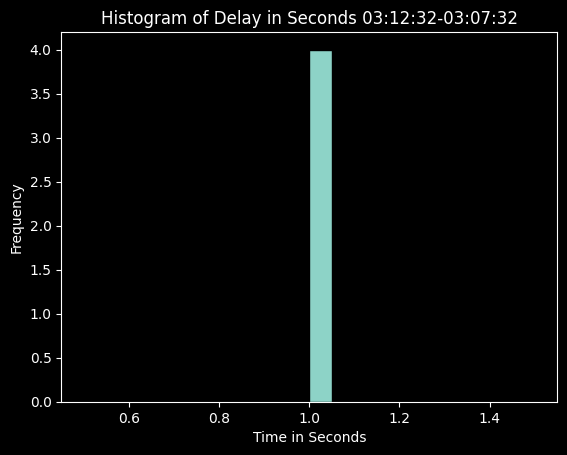

633
first 2024-11-05 03:07:31
first ['2024-11-05T03:07:31.000000000'] ['6729e053124bd56498eadc02']
last ['2024-11-05T03:05:28.000000000'] ['6729dfd869994fdacd6fe387']


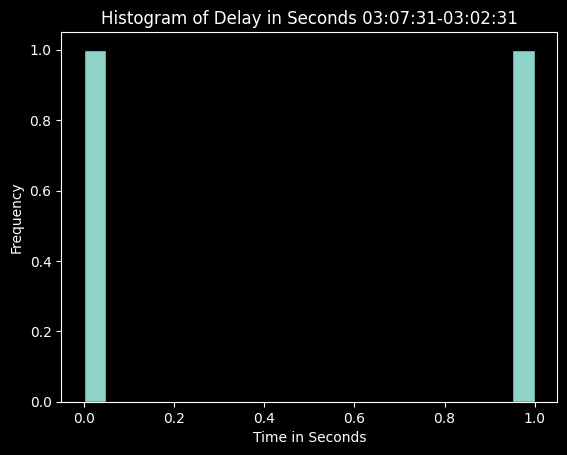

635
first 2024-11-05 02:59:18
first ['2024-11-05T02:59:18.000000000'] ['6729de66124bd56498eadc00']
last ['2024-11-05T02:59:18.000000000'] ['6729de66124bd56498eadc00']


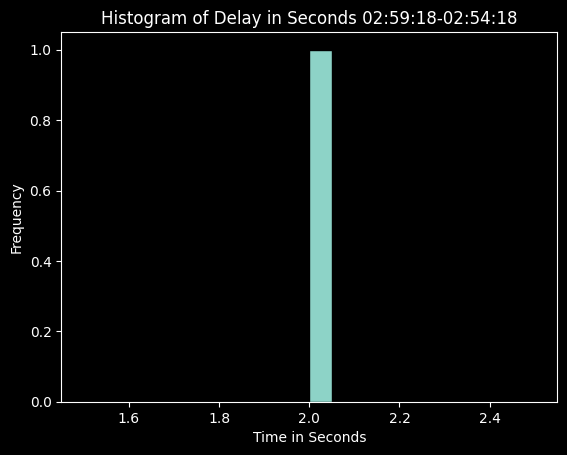

636
first 2024-11-05 02:46:45
first ['2024-11-05T02:46:45.000000000'] ['6729db75124bd56498eadbfe']
last ['2024-11-05T02:41:48.000000000'] ['6729da4c69994fdacd6fe36f']


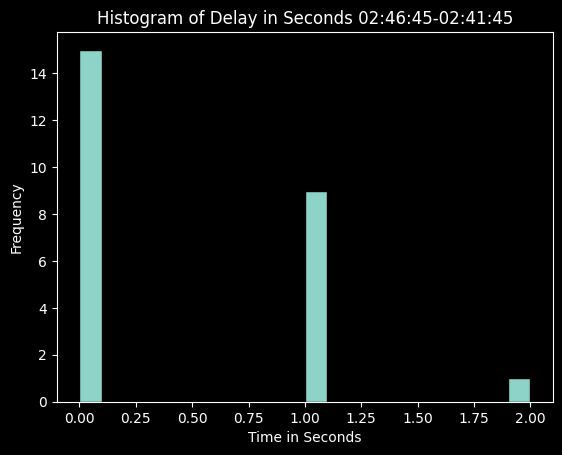

661
first 2024-11-05 02:41:37
first ['2024-11-05T02:41:37.000000000'] ['6729da4169994fdacd6fe36d']
last ['2024-11-05T02:36:44.000000000'] ['6729d91c124bd56498eadbd2']


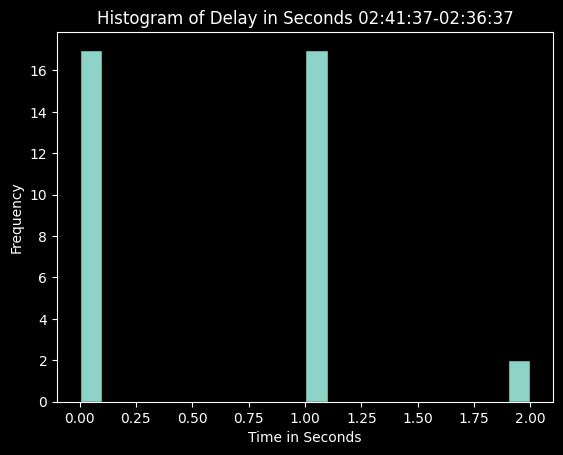

697
first 2024-11-05 02:35:48
first ['2024-11-05T02:35:48.000000000'] ['6729d8e4124bd56498eadbd0']
last ['2024-11-05T02:31:23.000000000'] ['6729d7db69994fdacd6fe351']


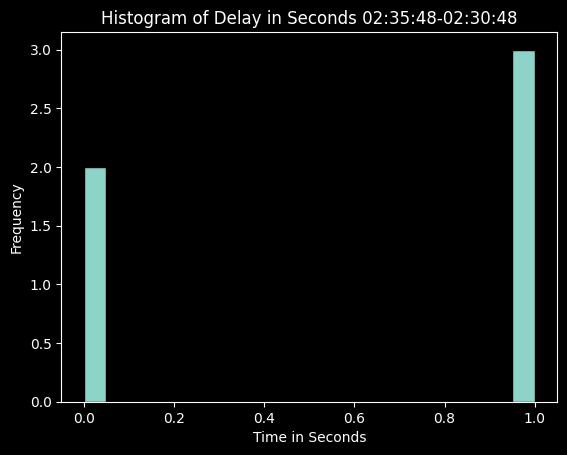

702
first 2024-11-05 02:30:34
first ['2024-11-05T02:30:34.000000000'] ['6729d7aa124bd56498eadbca']
last ['2024-11-05T02:26:46.000000000'] ['6729d6c6124bd56498eadbc8']


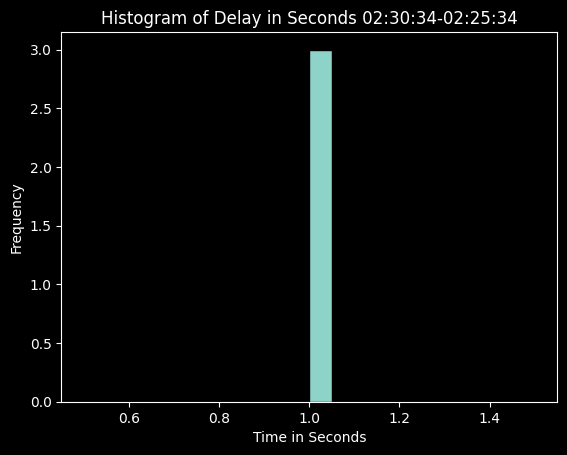

705
first 2024-11-05 02:18:20
first ['2024-11-05T02:18:20.000000000'] ['6729d4cc7384826621095c10']
last ['2024-11-05T02:17:08.000000000'] ['6729d4847384826621095c0c']


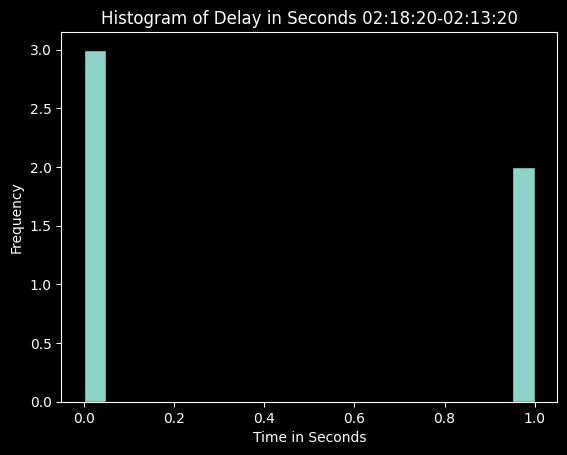

710
first 2024-11-05 02:12:50
first ['2024-11-05T02:12:50.000000000'] ['6729d382124bd56498eadbc6']
last ['2024-11-05T02:12:50.000000000'] ['6729d382124bd56498eadbc6']


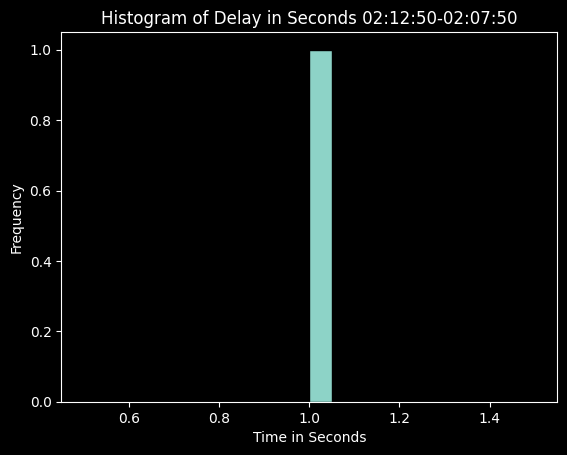

711
first 2024-11-05 02:02:03
first ['2024-11-05T02:02:03.000000000'] ['6729d0fb7384826621095c0a']
last ['2024-11-05T01:58:34.000000000'] ['6729d02a69994fdacd6fe347']


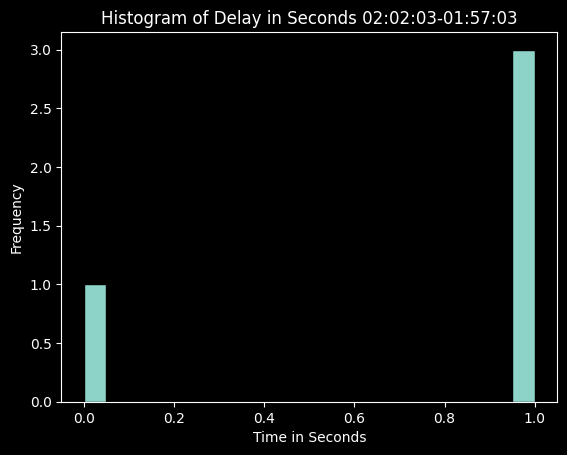

715
first 2024-11-05 01:54:51
first ['2024-11-05T01:54:51.000000000'] ['6729cf4b7384826621095c08']
last ['2024-11-05T01:51:54.000000000'] ['6729ce9a124bd56498eadbbc']


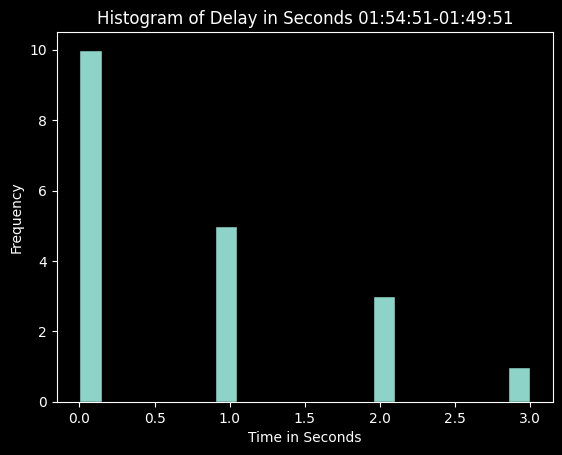

734
first 2024-11-05 01:40:58
first ['2024-11-05T01:40:58.000000000'] ['6729cc0a124bd56498eadbba']
last ['2024-11-05T01:40:58.000000000'] ['6729cc0a124bd56498eadbba']


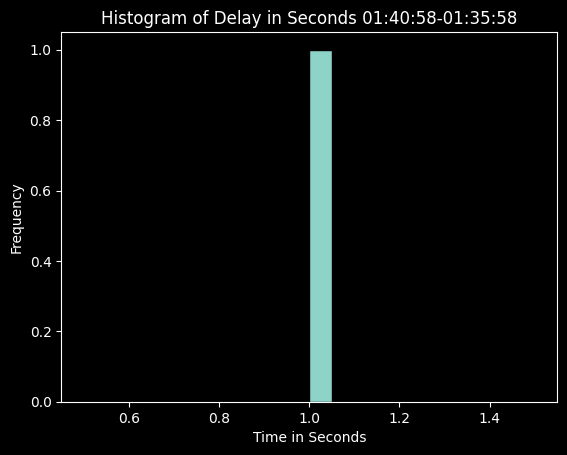

735
first 2024-11-05 01:25:45
first ['2024-11-05T01:25:45.000000000'] ['6729c879124bd56498eadbb8']
last ['2024-11-05T01:23:41.000000000'] ['6729c7fd69994fdacd6fe335']


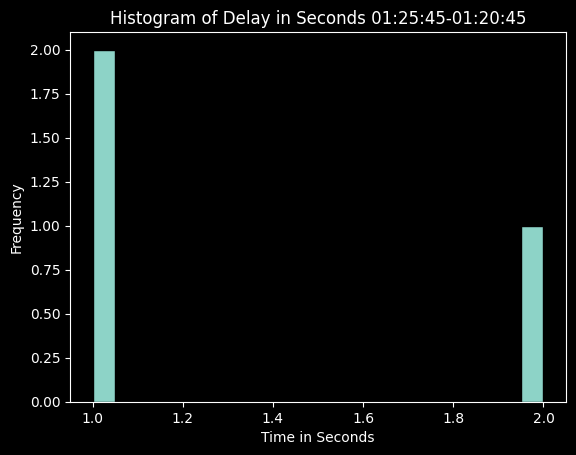

738
first 2024-11-05 01:12:59
first ['2024-11-05T01:12:59.000000000'] ['6729c57b124bd56498eadbb6']
last ['2024-11-05T01:08:39.000000000'] ['6729c47769994fdacd6fe32f']


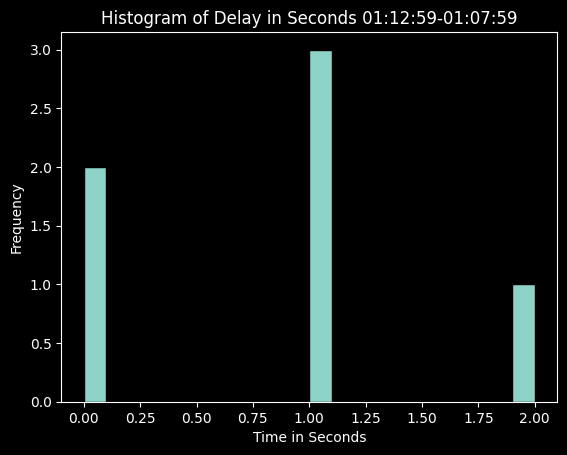

744
first 2024-11-05 01:01:21
first ['2024-11-05T01:01:21.000000000'] ['6729c2c169994fdacd6fe32d']
last ['2024-11-05T01:00:39.000000000'] ['6729c297124bd56498eadbb2']


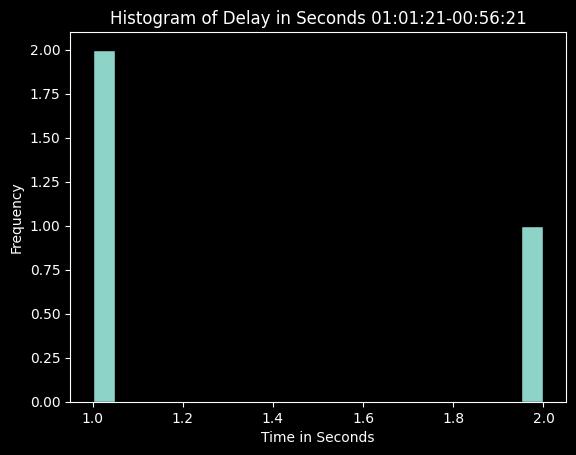

747
first 2024-11-05 00:51:16
first ['2024-11-05T00:51:16.000000000'] ['6729c06469994fdacd6fe32b']
last ['2024-11-05T00:48:35.000000000'] ['6729bfc37384826621095bf2']


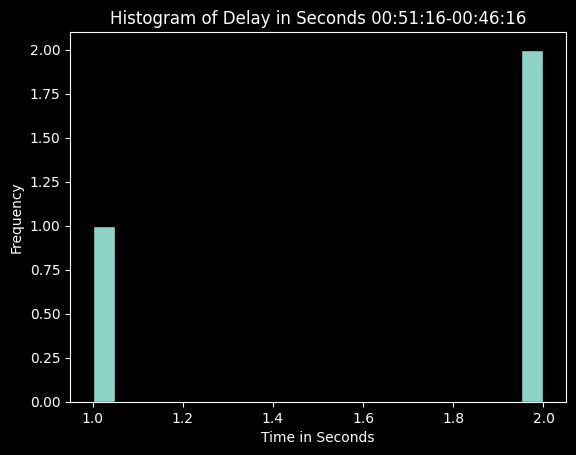

750
first 2024-11-05 00:45:20
first ['2024-11-05T00:45:20.000000000'] ['6729bf007384826621095bf0']
last ['2024-11-05T00:45:04.000000000'] ['6729bef069994fdacd6fe329']


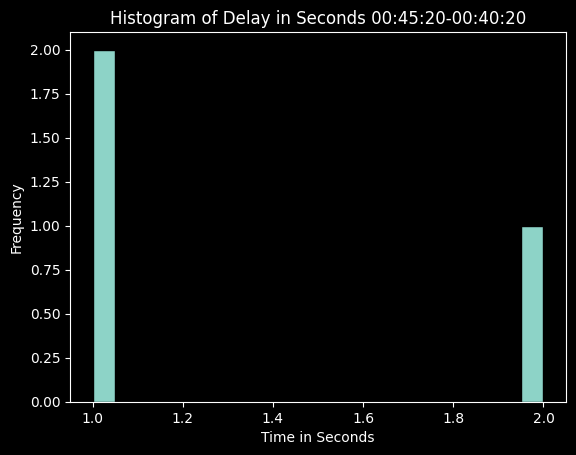

753
first 2024-11-05 00:37:17
first ['2024-11-05T00:37:17.000000000'] ['6729bd1d7384826621095bec']
last ['2024-11-05T00:36:23.000000000'] ['6729bce7124bd56498eadbb0']


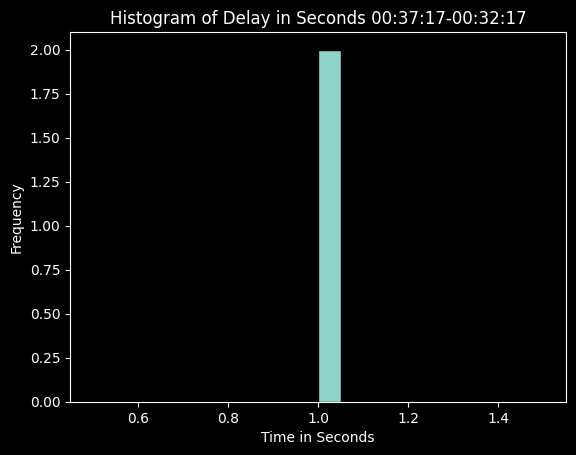

755
first 2024-11-05 00:25:12
first ['2024-11-05T00:25:12.000000000'] ['6729ba4869994fdacd6fe327']
last ['2024-11-05T00:20:57.000000000'] ['6729b9497384826621095be4']


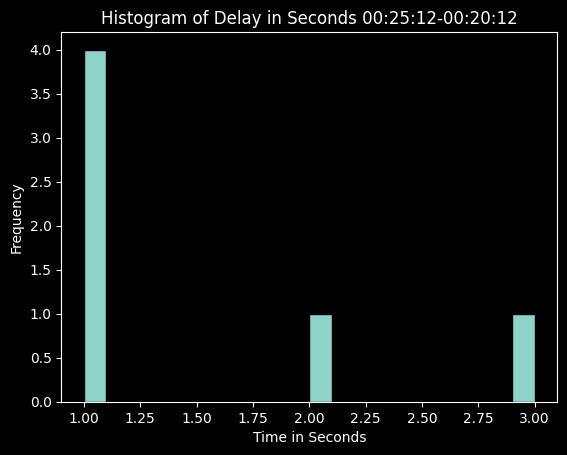

761
first 2024-11-05 00:19:44
first ['2024-11-05T00:19:44.000000000'] ['6729b900124bd56498eadbac']
last ['2024-11-05T00:17:36.000000000'] ['6729b880124bd56498eadbaa']


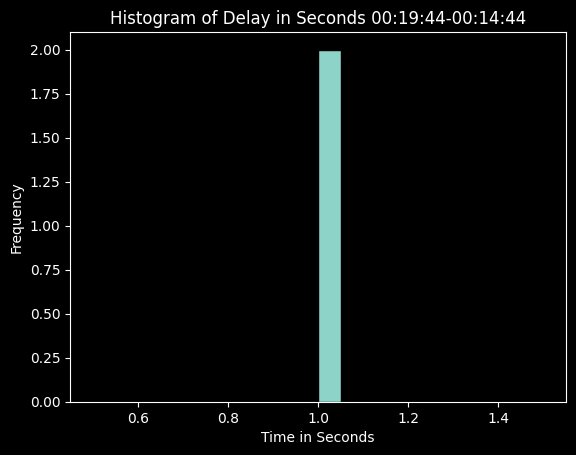

763
first 2024-11-05 00:13:36
first ['2024-11-05T00:13:36.000000000'] ['6729b79069994fdacd6fe325']
last ['2024-11-05T00:10:15.000000000'] ['6729b6c77384826621095bdc']


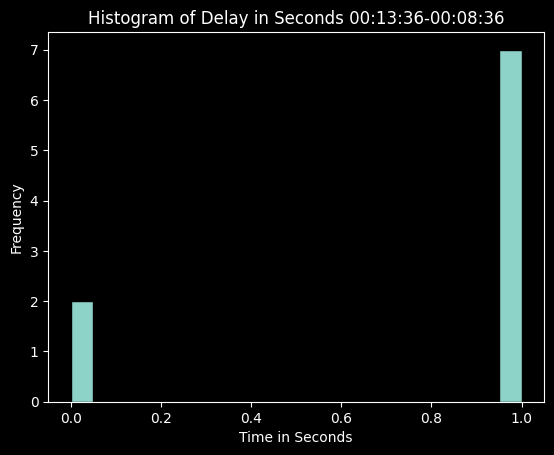

772
first 2024-11-05 00:05:59
first ['2024-11-05T00:05:59.000000000'] ['6729b5c7124bd56498eadba2']
last ['2024-11-05T00:03:00.000000000'] ['6729b514124bd56498eadb9c']


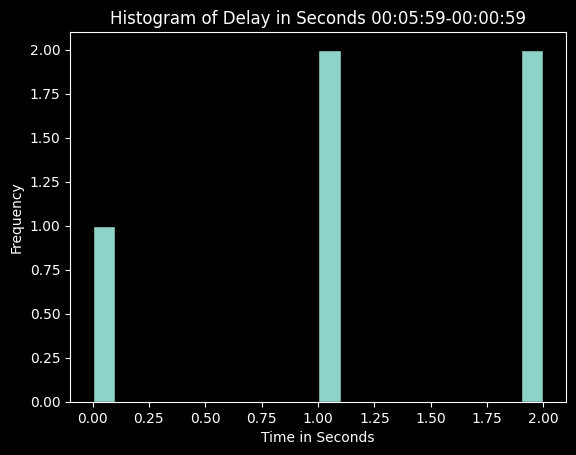

777
first 2024-11-04 23:57:43
first ['2024-11-04T23:57:43.000000000'] ['6729b3d77384826621095bd8']
last ['2024-11-04T23:52:46.000000000'] ['6729b2ae7384826621095bce']


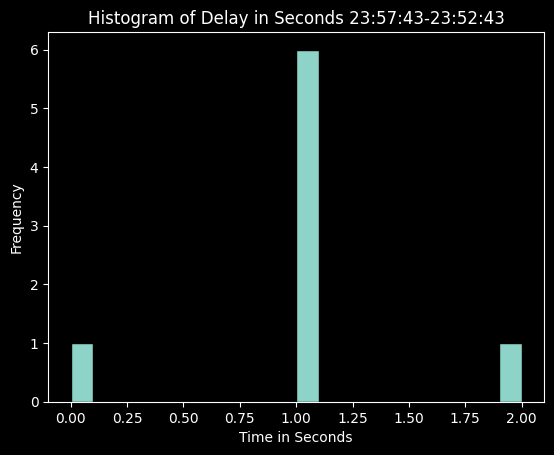

785
first 2024-11-04 23:52:25
first ['2024-11-04T23:52:25.000000000'] ['6729b29969994fdacd6fe31f']
last ['2024-11-04T23:47:44.000000000'] ['6729b1807384826621095bca']


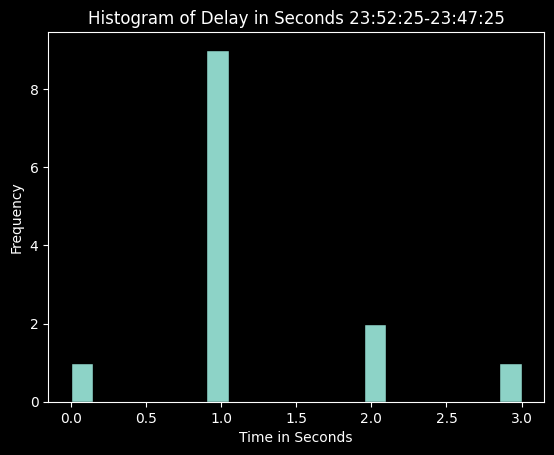

798
first 2024-11-04 23:47:16
first ['2024-11-04T23:47:16.000000000'] ['6729b16469994fdacd6fe315']
last ['2024-11-04T23:42:37.000000000'] ['6729b04d7384826621095bc0']


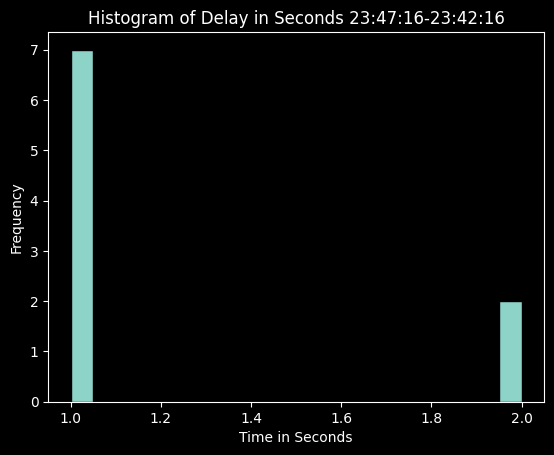

807
first 2024-11-04 23:42:15
first ['2024-11-04T23:42:15.000000000'] ['6729b0377384826621095bbe']
last ['2024-11-04T23:39:32.000000000'] ['6729af947384826621095bba']


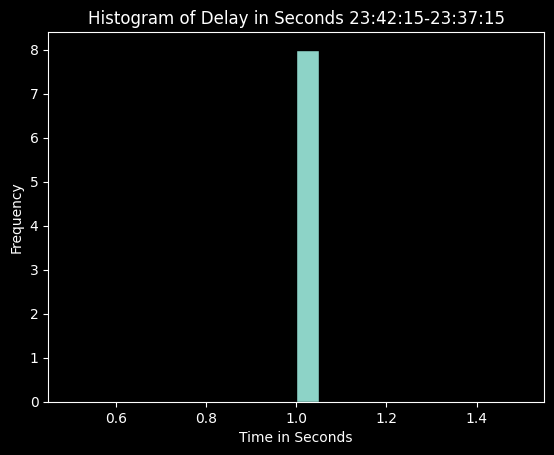

815
first 2024-11-04 23:36:59
first ['2024-11-04T23:36:59.000000000'] ['6729aefb7384826621095bb8']
last ['2024-11-04T23:32:05.000000000'] ['6729add57384826621095bac']


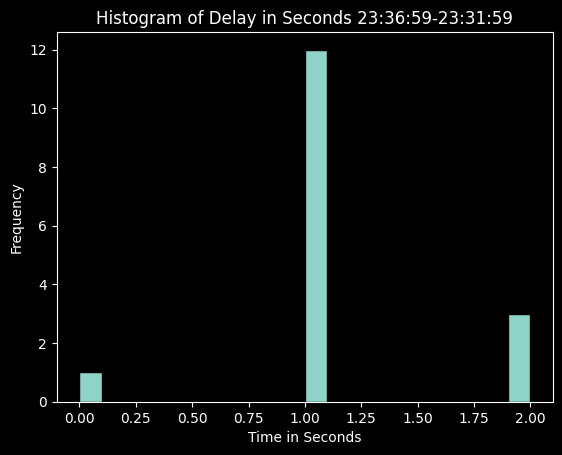

831
first 2024-11-04 23:31:59
first ['2024-11-04T23:31:59.000000000'] ['6729adcf69994fdacd6fe305']
last ['2024-11-04T23:27:52.000000000'] ['6729acd8124bd56498eadb6c']


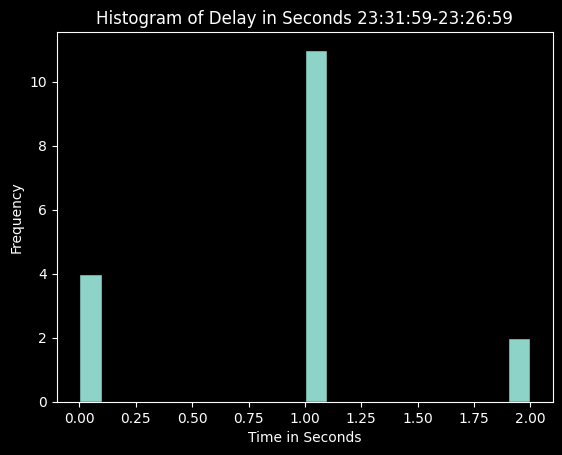

848
first 2024-11-04 23:26:41
first ['2024-11-04T23:26:41.000000000'] ['6729ac9169994fdacd6fe2f9']
last ['2024-11-04T23:21:58.000000000'] ['6729ab76124bd56498eadb5a']


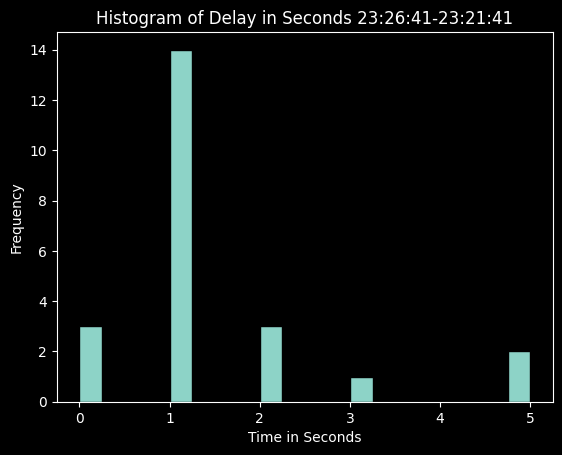

871
first 2024-11-04 23:21:40
first ['2024-11-04T23:21:40.000000000'] ['6729ab64124bd56498eadb58']
last ['2024-11-04T23:17:04.000000000'] ['6729aa50124bd56498eadb4c']


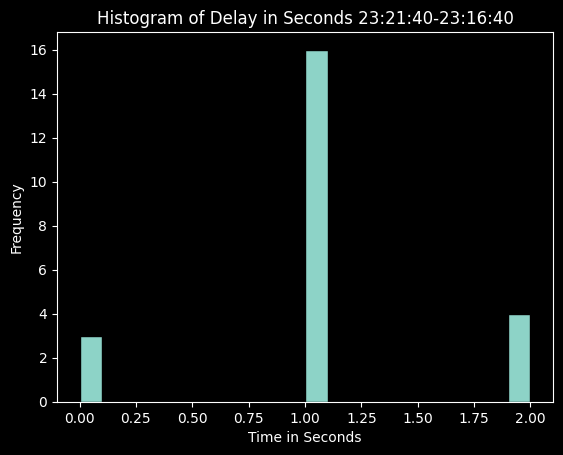

894
first 2024-11-04 23:16:26
first ['2024-11-04T23:16:26.000000000'] ['6729aa2a7384826621095b86']
last ['2024-11-04T23:11:41.000000000'] ['6729a90d124bd56498eadb40']


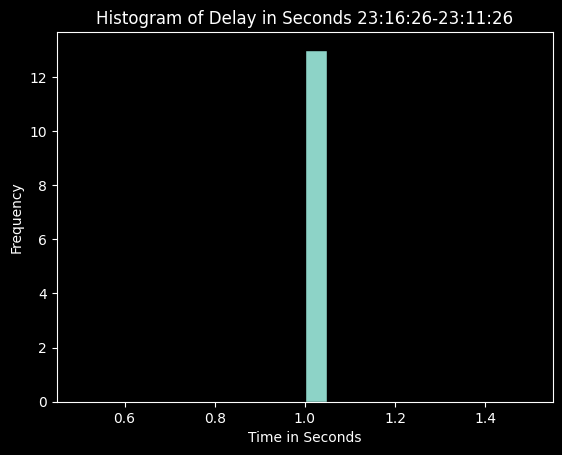

907
first 2024-11-04 23:11:26
first ['2024-11-04T23:11:26.000000000'] ['6729a8fe7384826621095b7c']
last ['2024-11-04T23:06:43.000000000'] ['6729a7e369994fdacd6fe2bd']


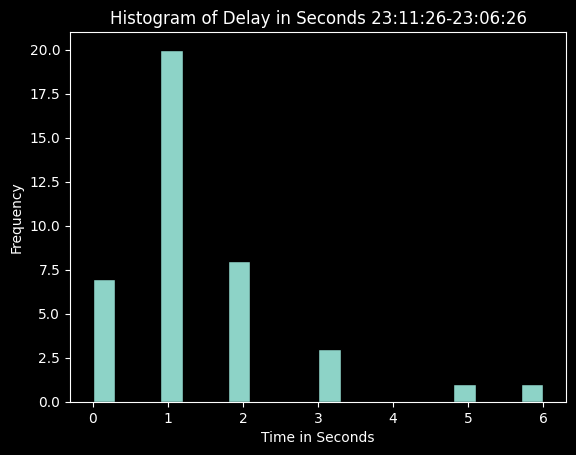

947
first 2024-11-04 23:06:09
first ['2024-11-04T23:06:09.000000000'] ['6729a7c1124bd56498eadb22']
last ['2024-11-04T23:01:48.000000000'] ['6729a6bc7384826621095b54']


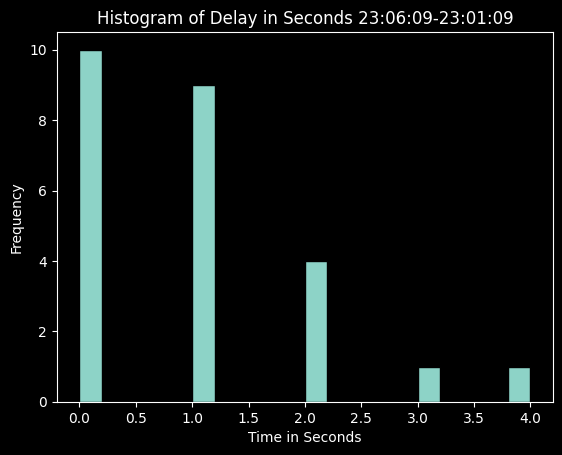

972
first 2024-11-04 23:01:00
first ['2024-11-04T23:01:00.000000000'] ['6729a68c124bd56498eadb12']
last ['2024-11-04T22:57:05.000000000'] ['6729a5a1124bd56498eadb08']


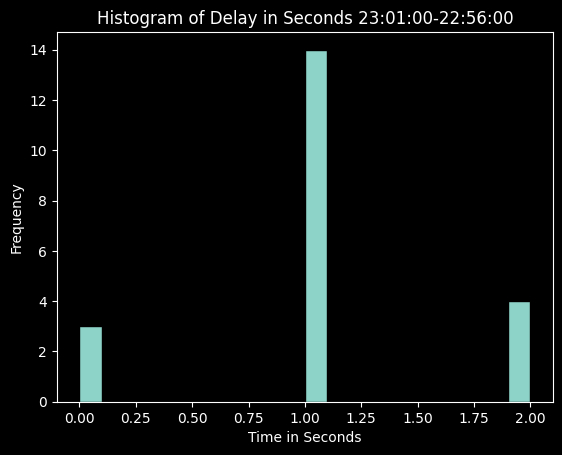

993
first 2024-11-04 22:55:55
first ['2024-11-04T22:55:55.000000000'] ['6729a55b124bd56498eadb06']
last ['2024-11-04T22:52:47.000000000'] ['6729a49f69994fdacd6fe293']


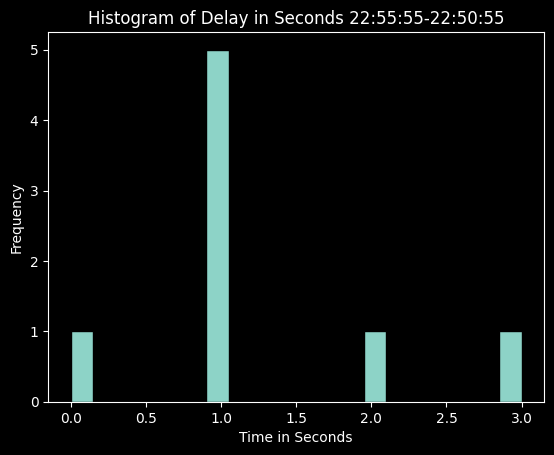

1001
CPU times: total: 0 ns
Wall time: 0 ns


In [13]:
filteredAnalysis = DataFrame_analysis()
n_minutes = 5
maxTimeAllowed = 6
totalRows = filteredAnalysis.getDfSize(regularizationFrame)['rows']
partialRows = 1
recordsAnalysis = []
codesAnalysis = []
vinsAnalysis = []
regularizationFrame['responseTime'] = pd.to_datetime(regularizationFrame['responseTime'], format='%d/%m/%Y %H:%M:%S')
dataframeIndex=0


while partialRows < totalRows:
    #DATA SEPARATION BY TIME LAPSE n_minutes
    first_timestamp = regularizationFrame['responseTime'].iloc[partialRows-1]
    print('first', first_timestamp)
    time_threshold = first_timestamp - pd.Timedelta(minutes=n_minutes)
    filtered_df = regularizationFrame[(regularizationFrame['responseTime'] > time_threshold) & (regularizationFrame['responseTime'] <= first_timestamp)].fillna('xD')
    print('first', filtered_df['responseTime'].values[0:1], filtered_df['idRespuesta'].values[0:1])
    print('last',filtered_df['responseTime'].values[-1:], filtered_df['idRespuesta'].values[-1:])
    timeLapse = '- '.join([str(first_timestamp),str(time_threshold)])
    
    ##SHAPE DATA ANALYSIS
    if list(filteredAnalysis.determineDistinctKeys(filtered_df['requestParameters']).keys()) !=['']:
        print('Existen peticiones con RequestParameters inconvencionales')
    if list(filteredAnalysis.determineDistinctValues(filtered_df, 'apiKey'))!=['6cNqbbTqBnZEchPZ2YYn']:
        print('Existen peticiones con distinta ApiKey')  
    if list(filteredAnalysis.determineDistinctValues(filtered_df, 'userId'))!=['xD']:
        print('Existen peticiones con distinto userId')  
    if list(filteredAnalysis.determineDistinctValues(filtered_df, 'responseCode'))!=[200] and filteredAnalysis.determineDistinctValues(filtered_df, 'responseCodeStatus').values.list()!=['ok']:
        print('Existen peticiones con distinto responseCode')
    if list(filteredAnalysis.determineDistinctValues(filtered_df, 'labels'))!=['xD']:
        print('Existen peticiones con distinto labels')
    if list(filteredAnalysis.determineDistinctValues(filtered_df, 'firewallUsa'))!=[0]:
        print('Existen peticiones con distinto firewallUsa')
    totalRecords = filteredAnalysis.getDfSize(filtered_df)['rows']
    
    ##CONTENT DATA ANALYSIS
    
    #Alerts Analysis
    codeCount = filteredAnalysis.countAlertCodes(filtered_df, 'alertas')
    codesAnalysis.append([timeLapse])
    for code in codeCount.keys():
        codesAnalysis[dataframeIndex].append(codeCount[code])

    #Response Time Analysis
    responseTime = filteredAnalysis.calculateDeltaTime(filtered_df, 'responseTime', 'requestTime')
    plt.hist(responseTime['secondsDifference'], bins = 20, edgecolor = 'black')
    plt.xlabel('Time in Seconds')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Delay in Seconds {''.join([timeLapse.split(' ')[1],timeLapse.split(' ')[3]])}')
    plt.show()

    maxTimeResponse = responseTime.max().values.tolist()[0]
    if maxTimeResponse > maxTimeAllowed:
        print('Existen peticiones que están tardando en responder más de lo usual: ', str(maxTimeResponse))

    #Congruence CarfaxUsaData-Alerts
    if filteredAnalysis.proveErrorAlert(filtered_df):
        print('Existen registros con error y sin alerta')

    #Good-Bad VINs Relation
    vinsRelations = filteredAnalysis.getIncorrectRepeatedVinInformation(filtered_df)
    if vinsRelations['message']!='':
        print( vinsRelations['message'])
    else:
        goodVins=vinsRelations['goodVins']
        badVins=vinsRelations['badVins']
        vinsAnalysis.append([timeLapse, badVins+goodVins, goodVins, badVins])
        
    #Good-Bad Records Relations
    framesSources = filteredAnalysis.diagnoseVins(filtered_df)
    goodRecords = filteredAnalysis.diagnoseVins(filtered_df)['goodRepeatedRecords']
    badRecords = filteredAnalysis.diagnoseVins(filtered_df)['badRepeatedRecords']
    recordsAnalysis.append([timeLapse, totalRecords, goodRecords, badRecords])

    #Review congruent information Repeated Vins
    if filteredAnalysis.verifyInfoRepeatedVins(filtered_df)['differentResponses'] != {}:
         print('Existen respuestas distintas para un mismo VIN: ', verifyInfoRepeatedVins(df)['differentResponses'])
     
    partialRows += totalRecords  
    print(partialRows)
    dataframeIndex+=1

%time

In [6]:
vinsFrame = pd.DataFrame(vinsAnalysis, columns=['timeLapse', 'total', 'right', 'wrong'])
recordsFrame = pd.DataFrame(recordsAnalysis, columns = ['timeLapse', 'total', 'right', 'wrong'])
codesFrame = pd.DataFrame(codesAnalysis, columns = ['timeLapse', 'code1', 'code2', 'code3', 'code4', 'code5', 'code6', 'code7'])

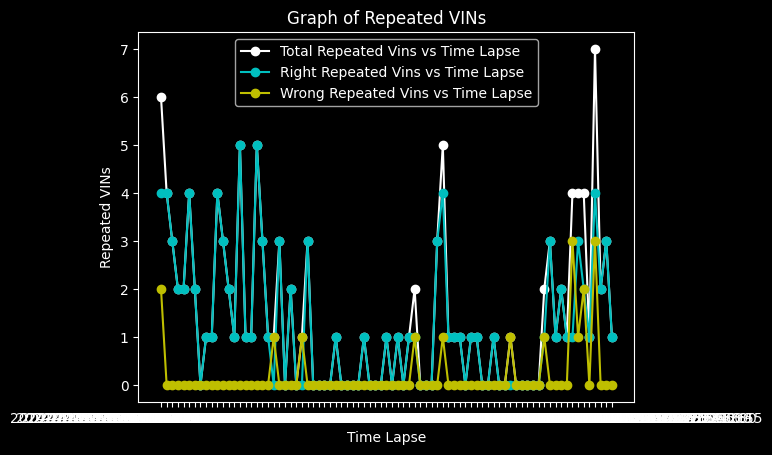

In [7]:
plt.plot(vinsFrame['timeLapse'], vinsFrame['total'], marker='o', linestyle='-', color='w', label = 'Total Repeated Vins vs Time Lapse')
plt.plot(vinsFrame['timeLapse'], vinsFrame['right'], marker='o', linestyle='-', color='c', label = 'Right Repeated Vins vs Time Lapse')
plt.plot(vinsFrame['timeLapse'], vinsFrame['wrong'], marker='o', linestyle='-', color='y', label = 'Wrong Repeated Vins vs Time Lapse')
plt.xlabel('Time Lapse')
plt.ylabel('Repeated VINs')
plt.title('Graph of Repeated VINs')
plt.legend()
plt.show()

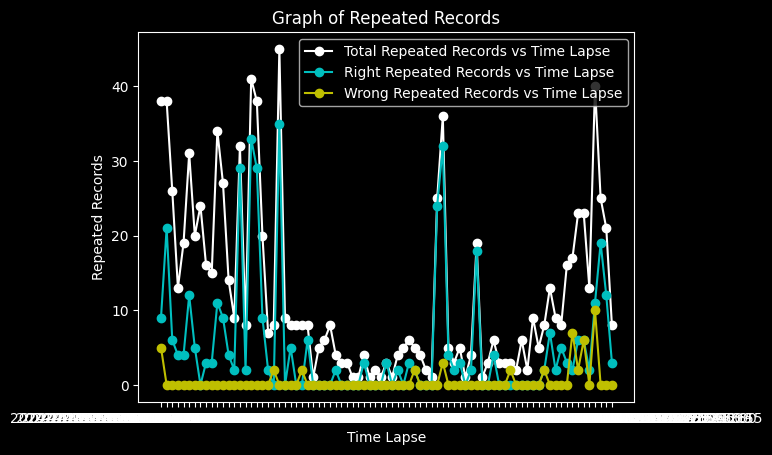

In [8]:
plt.plot(recordsFrame['timeLapse'], recordsFrame['total'], marker='o', linestyle='-', color='w', label = 'Total Repeated Records vs Time Lapse')
plt.plot(recordsFrame['timeLapse'], recordsFrame['right'], marker='o', linestyle='-', color='c', label = 'Right Repeated Records vs Time Lapse')
plt.plot(recordsFrame['timeLapse'], recordsFrame['wrong'], marker='o', linestyle='-', color='y', label = 'Wrong Repeated Records vs Time Lapse')
plt.xlabel('Time Lapse')
plt.ylabel('Repeated Records')
plt.title('Graph of Repeated Records')
plt.legend()
plt.show()

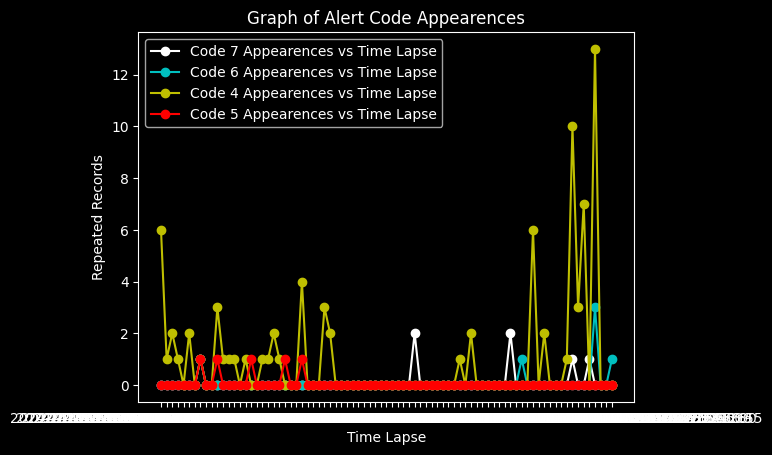

In [9]:
plt.plot(codesFrame['timeLapse'], codesFrame['code7'], marker='o', linestyle='-', color='w', label = 'Code 7 Appearences vs Time Lapse')
plt.plot(codesFrame['timeLapse'], codesFrame['code6'], marker='o', linestyle='-', color='c', label = 'Code 6 Appearences vs Time Lapse')
plt.plot(codesFrame['timeLapse'], codesFrame['code4'], marker='o', linestyle='-', color='y', label = 'Code 4 Appearences vs Time Lapse')
plt.plot(codesFrame['timeLapse'], codesFrame['code5'], marker='o', linestyle='-', color='r', label = 'Code 5 Appearences vs Time Lapse')
plt.xlabel('Time Lapse')
plt.ylabel('Repeated Records')
plt.title('Graph of Alert Code Appearences')
plt.legend()
plt.show()

In [10]:
codesFrame.sum()

timeLapse    2024-11-05 10:14:00- 2024-11-05 10:09:002024-1...
code1                                                       14
code2                                                        0
code3                                                        3
code4                                                       79
code5                                                        5
code6                                                        6
code7                                                        7
dtype: object

In [11]:
recordsFrame.sum()

timeLapse    2024-11-05 10:14:00- 2024-11-05 10:09:002024-1...
total                                                     1000
right                                                      427
wrong                                                       43
dtype: object

In [12]:
vinsFrame.sum()

timeLapse    2024-11-05 10:14:00- 2024-11-05 10:09:002024-1...
total                                                      118
right                                                      101
wrong                                                       17
dtype: object

## 